In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mplfinance as mpf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy import stats
import cvxpy as cp

# List of stock tickers
tickers = ['BWEN', 'STGW', 'PLTK', "TAYD", "^GSPC", "^NDX", "DJI"]

# Create an empty DataFrame to hold the stock data
stock_data = pd.DataFrame()

# Fetch and analyze stock data for each ticker
for ticker in tickers:
    # Download historical data
    stock = yf.Ticker(ticker)
    hist_data = stock.history(period="5y")
    
    # Calculate 14-day RSI
    delta = hist_data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    # Add RSI to historical data
    hist_data['RSI'] = rsi
    
    # Append data to the main DataFrame
    hist_data['Ticker'] = ticker
    stock_data = pd.concat([stock_data, hist_data])

In [2]:
stock_data

Open          High           Low  \
Date                                                                  
2018-08-21 00:00:00-04:00      2.190000      2.250000      2.110000   
2018-08-22 00:00:00-04:00      2.140000      2.220000      2.110000   
2018-08-23 00:00:00-04:00      2.130000      2.180000      2.080000   
2018-08-24 00:00:00-04:00      2.090000      2.130000      2.060000   
2018-08-27 00:00:00-04:00      2.080000      2.110000      2.070000   
...                                 ...           ...           ...   
2022-02-24 00:00:00-05:00  33223.800781  33223.800781  33223.800781   
2022-02-25 00:00:00-05:00  34058.800781  34058.800781  34058.800781   
2022-02-28 00:00:00-05:00  33892.601562  33892.601562  33892.601562   
2022-03-01 00:00:00-05:00  33294.898438  33294.898438  33294.898438   
2022-03-02 00:00:00-05:00  33891.300781  33891.300781  33891.300781   

                                  Close  Volume  Dividends  Stock Splits  \
Date                                                                       
2018-08-21 00:00:00-04:00      2.150000   27000        0.0           0.0   
2018-08-22 00:00:00-04:00      2.110000   36900        0.0           0.0   
2018-08-23 00:00:00-04:00      2.090000   56600        0.0           0.0   
2018-08-24 00:00:00-04:00      2.080000   34200        0.0           0.0   
2018-08-27 00:00:00-04:00      2.070000  105600        0.0           0.0   
...                                 ...     ...        ...           ...   
2022-02-24 00:00:00-05:00  33223.800781       0        0.0           0.0   
2022-02-25 00:00:00-05:00  34058.800781       0        0.0           0.0   
2022-02-28 00:00:00-05:00  33892.601562       0        0.0           0.0   
2022-03-01 00:00:00-05:00  33294.898438       0        0.0           0.0   
2022-03-02 00:00:00-05:00  33891.300781       0        0.0           0.0   

                                 RSI Ticker  
Date                                         
2018-08-21 00:00:00-04:00        NaN   BWEN  
2018-08-22 00:00:00-04:00        NaN   BWEN  
2018-08-23 00:00:00-04:00        NaN   BWEN  
2018-08-24 00:00:00-04:00        NaN   BWEN  
2018-08-27 00:00:00-04:00        NaN   BWEN  
...                              ...    ...  
2022-02-24 00:00:00-05:00  27.916932    DJI  
2022-02-25 00:00:00-05:00  39.867137    DJI  
2022-02-28 00:00:00-05:00  38.589416    DJI  
2022-03-01 00:00:00-05:00  30.211589    DJI  
2022-03-02 00:00:00-05:00  33.733203    DJI  

[7659 rows x 9 columns]

In [3]:
"""
competitors for Broadwind: "industrial products" sector
TechPrecision (TPCS), Molekule Group (MKUL), Research Solutions (RSSS), Pioneer Power Solutions (PPSI), Ampco-Pittsburgh (AP), Advanced Emissions Solutions (ADES), Ideal Power (IPWR), Perma-Pipe International (PPIH), Wrap Technologies (WRAP), and Taylor Devices (TAYD)

competitors for Stagwell (STGW): sector: "business services"
NV5 Global (NVEE), B. Riley Financial (RILY), Inter & Co, Inc. (INTR), Thoughtworks (TWKS), V2X (VVX), HNI (HNI), Bitdeer Technologies Group (BTDR), Cellebrite DI (CLBT), MeridianLink (MLNK), and Veradigm (MDRX).

The main competitors of Playtika include SciPlay (SCPL), Sendas Distribuidora (ASAI), Acushnet (GOLF), PENN Entertainment (PENN), Under Armour (UAA), TEGNA (TGNA), Leggett & Platt (LEG), Cable One (CABO), Grand Canyon Education (LOPE), and Manchester United (MANU). These companies are all part of the "consumer discretionary" sector.

"""

'\ncompetitors for Broadwind: "industrial products" sector\nTechPrecision (TPCS), Molekule Group (MKUL), Research Solutions (RSSS), Pioneer Power Solutions (PPSI), Ampco-Pittsburgh (AP), Advanced Emissions Solutions (ADES), Ideal Power (IPWR), Perma-Pipe International (PPIH), Wrap Technologies (WRAP), and Taylor Devices (TAYD)\n\ncompetitors for Stagwell (STGW): sector: "business services"\nNV5 Global (NVEE), B. Riley Financial (RILY), Inter & Co, Inc. (INTR), Thoughtworks (TWKS), V2X (VVX), HNI (HNI), Bitdeer Technologies Group (BTDR), Cellebrite DI (CLBT), MeridianLink (MLNK), and Veradigm (MDRX).\n\nThe main competitors of Playtika include SciPlay (SCPL), Sendas Distribuidora (ASAI), Acushnet (GOLF), PENN Entertainment (PENN), Under Armour (UAA), TEGNA (TGNA), Leggett & Platt (LEG), Cable One (CABO), Grand Canyon Education (LOPE), and Manchester United (MANU). These companies are all part of the "consumer discretionary" sector.\n\n'

In [4]:
BWEN_comp = ["PPIH", "FATH", "TAYD", "PPSI", "IPWR", "WRAP", "AP", "ADES", "RSSS", "ISDR"]

STGW_comp = ["NVEE", "RILY", "INTR", "TWKS", "VVX", "HNI", "BTDR", "CLBT", "MLNK", "MDRX"]

PLTK_comp = ["SCPL", "ASAI", "GOLF", "PENN", "UAA", "TGNA", "LEG", "CABO", "LOPE", "MANU"]

competitor_set = set(BWEN_comp + STGW_comp + PLTK_comp)


In [5]:
def check_ticker_availability(ticker):
    # Try to fetch historical data for the ticker for a short period
    data = yf.download(ticker, start='2023-01-01', end='2023-01-10')
    
    # Check if the returned data is empty
    if data.empty:
        return False
    else:
        return True

# Test the function
is_available = check_ticker_availability('AAPL')  # Replace 'AAPL' with the ticker you want to check
if is_available:
    print("The ticker is available on Yahoo Finance.")
else:
    print("The ticker is not available on Yahoo Finance.")


[*********************100%***********************]  1 of 1 completed
The ticker is available on Yahoo Finance.


In [6]:
"""
industrial products:  S&P 500 Industrials Sector Index(S5INDU)

bussiness services: S&P 500 Information Technology Services Index S5INFT.

consumer discretionary: S&P 500 Consumer Discretionary S5COND

"""

'\nindustrial products:  S&P 500 Industrials Sector Index(S5INDU)\n\nbussiness services: S&P 500 Information Technology Services Index S5INFT.\n\nconsumer discretionary: S&P 500 Consumer Discretionary S5COND\n\n'

In [7]:
stock_data

Open          High           Low  \
Date                                                                  
2018-08-21 00:00:00-04:00      2.190000      2.250000      2.110000   
2018-08-22 00:00:00-04:00      2.140000      2.220000      2.110000   
2018-08-23 00:00:00-04:00      2.130000      2.180000      2.080000   
2018-08-24 00:00:00-04:00      2.090000      2.130000      2.060000   
2018-08-27 00:00:00-04:00      2.080000      2.110000      2.070000   
...                                 ...           ...           ...   
2022-02-24 00:00:00-05:00  33223.800781  33223.800781  33223.800781   
2022-02-25 00:00:00-05:00  34058.800781  34058.800781  34058.800781   
2022-02-28 00:00:00-05:00  33892.601562  33892.601562  33892.601562   
2022-03-01 00:00:00-05:00  33294.898438  33294.898438  33294.898438   
2022-03-02 00:00:00-05:00  33891.300781  33891.300781  33891.300781   

                                  Close  Volume  Dividends  Stock Splits  \
Date                                                                       
2018-08-21 00:00:00-04:00      2.150000   27000        0.0           0.0   
2018-08-22 00:00:00-04:00      2.110000   36900        0.0           0.0   
2018-08-23 00:00:00-04:00      2.090000   56600        0.0           0.0   
2018-08-24 00:00:00-04:00      2.080000   34200        0.0           0.0   
2018-08-27 00:00:00-04:00      2.070000  105600        0.0           0.0   
...                                 ...     ...        ...           ...   
2022-02-24 00:00:00-05:00  33223.800781       0        0.0           0.0   
2022-02-25 00:00:00-05:00  34058.800781       0        0.0           0.0   
2022-02-28 00:00:00-05:00  33892.601562       0        0.0           0.0   
2022-03-01 00:00:00-05:00  33294.898438       0        0.0           0.0   
2022-03-02 00:00:00-05:00  33891.300781       0        0.0           0.0   

                                 RSI Ticker  
Date                                         
2018-08-21 00:00:00-04:00        NaN   BWEN  
2018-08-22 00:00:00-04:00        NaN   BWEN  
2018-08-23 00:00:00-04:00        NaN   BWEN  
2018-08-24 00:00:00-04:00        NaN   BWEN  
2018-08-27 00:00:00-04:00        NaN   BWEN  
...                              ...    ...  
2022-02-24 00:00:00-05:00  27.916932    DJI  
2022-02-25 00:00:00-05:00  39.867137    DJI  
2022-02-28 00:00:00-05:00  38.589416    DJI  
2022-03-01 00:00:00-05:00  30.211589    DJI  
2022-03-02 00:00:00-05:00  33.733203    DJI  

[7659 rows x 9 columns]

In [8]:
def basic_metrics(stock_data):
    # Calculate the 50-day moving average
    stock_data['50_MA'] = stock_data['Close'].rolling(window=50).mean()

    # Calculate the 200-day moving average
    stock_data['200_MA'] = stock_data['Close'].rolling(window=200).mean()
    
    stock_data['50_SMA'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['200_SMA'] = stock_data['Close'].rolling(window=200).mean()
    
    # Calculating 50-day Exponential Moving Average
    stock_data['50_EMA'] = stock_data['Close'].ewm(span=50, adjust=False).mean()

    # Calculating 200-day Exponential Moving Average
    stock_data['200_EMA'] = stock_data['Close'].ewm(span=200, adjust=False).mean()

    # Calculate daily returns
    stock_data['Daily_Returns'] = stock_data['Close'].pct_change()

    # Calculate volatility (30-day standard deviation of daily returns)
    stock_data['Volatility'] = stock_data['Daily_Returns'].rolling(window=30).std()

    # Calculate Sharpe Ratio (assuming 0% risk-free rate)
    stock_data['Sharpe_Ratio'] = stock_data['Daily_Returns'].mean() / stock_data['Daily_Returns'].std()
    
    return stock_data

In [9]:
df = pd.DataFrame()
for ticker in tickers:
    df_temp = stock_data[stock_data["Ticker"]==ticker]
    df_temp = basic_metrics(df_temp)
    df = df.append(df_temp)
    
stock_data = df

/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/1073647460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['50_MA'] = stock_data['Close'].rolling(window=50).mean()
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/1073647460.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['200_MA'] = stock_data['Close'].rolling(window=200).mean()
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/1073647460.py:8: SettingWithCopyWarning: 
A value is try

In [10]:
def plots(stock_data, ticker):   
    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 20))

    # Plot stock prices and moving averages
    ax1.plot(stock_data['Close'], label='Stock Price', color='blue')
    ax1.plot(stock_data['50_MA'], label='50-day MA', color='green')
    ax1.plot(stock_data['200_MA'], label='200-day MA', color='red')
    ax1.set_title(f'Stock Price and Moving Averages for {ticker}')
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # Plot daily returns
    ax2.plot(stock_data['Daily_Returns'], label='Daily Returns', color='purple')
    ax2.set_title(f'Daily Returns for {ticker}')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Daily Returns')
    ax2.legend()
    ax2.grid(True)

    # Plot volatility
    ax3.plot(stock_data['Volatility'], label='Volatility (30-day)', color='orange')
    ax3.set_title(f'Volatility for {ticker}')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Volatility')
    ax3.legend()
    ax3.grid(True)

    # Plot Sharpe Ratio
    ax4.axhline(stock_data['Sharpe_Ratio'].mean(), color='brown', linestyle='--', label='Sharpe Ratio')
    ax4.set_title(f'Sharpe Ratio for {ticker}')
    ax4.set_xlabel('Days')
    ax4.set_ylabel('Sharpe Ratio')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

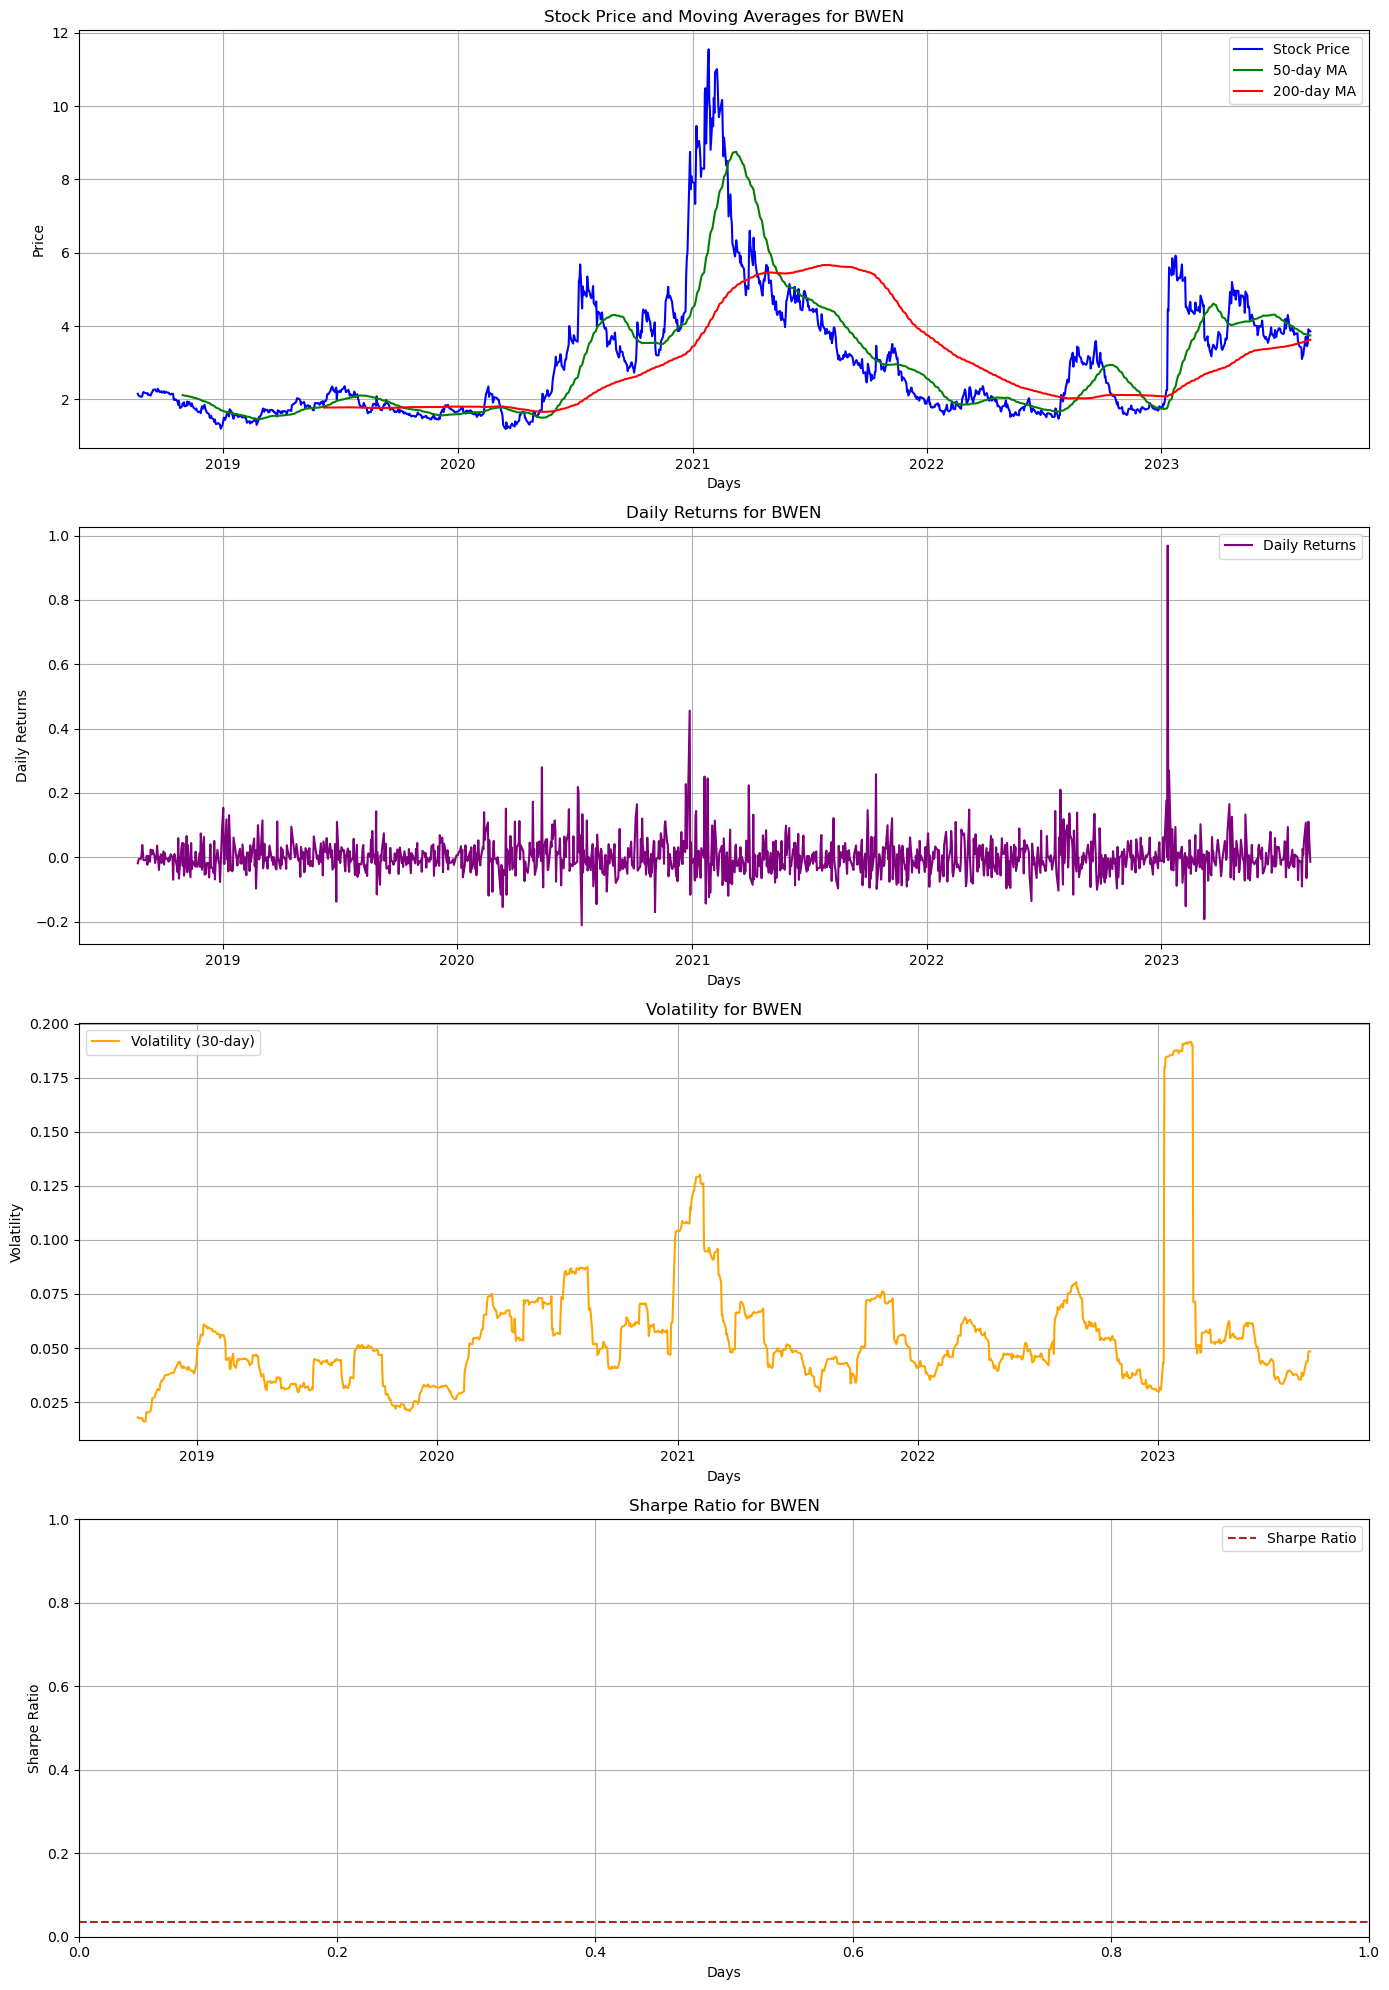

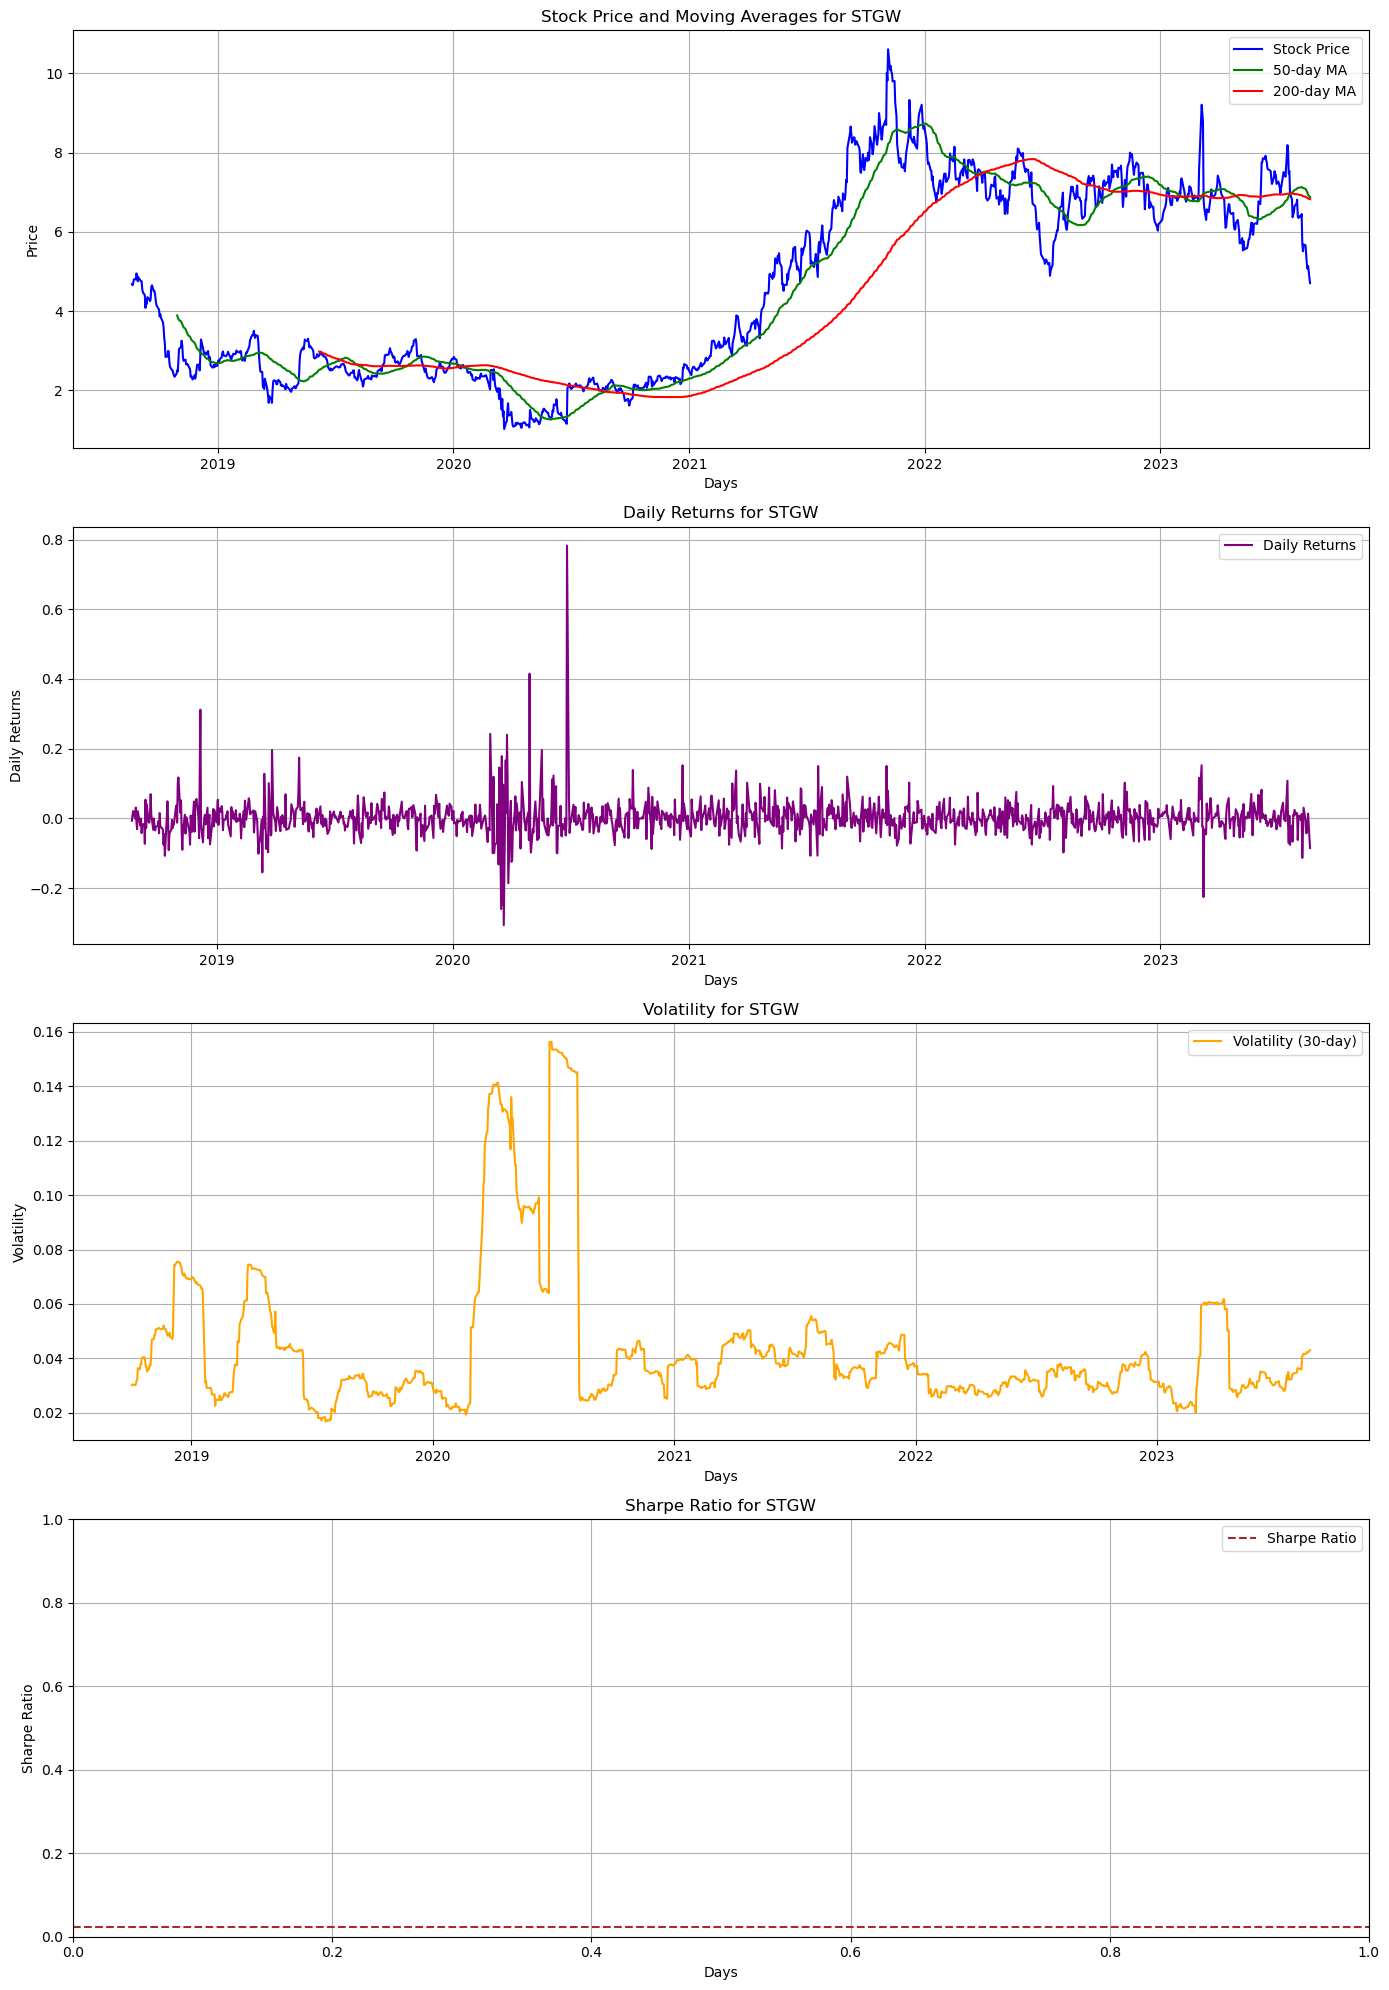

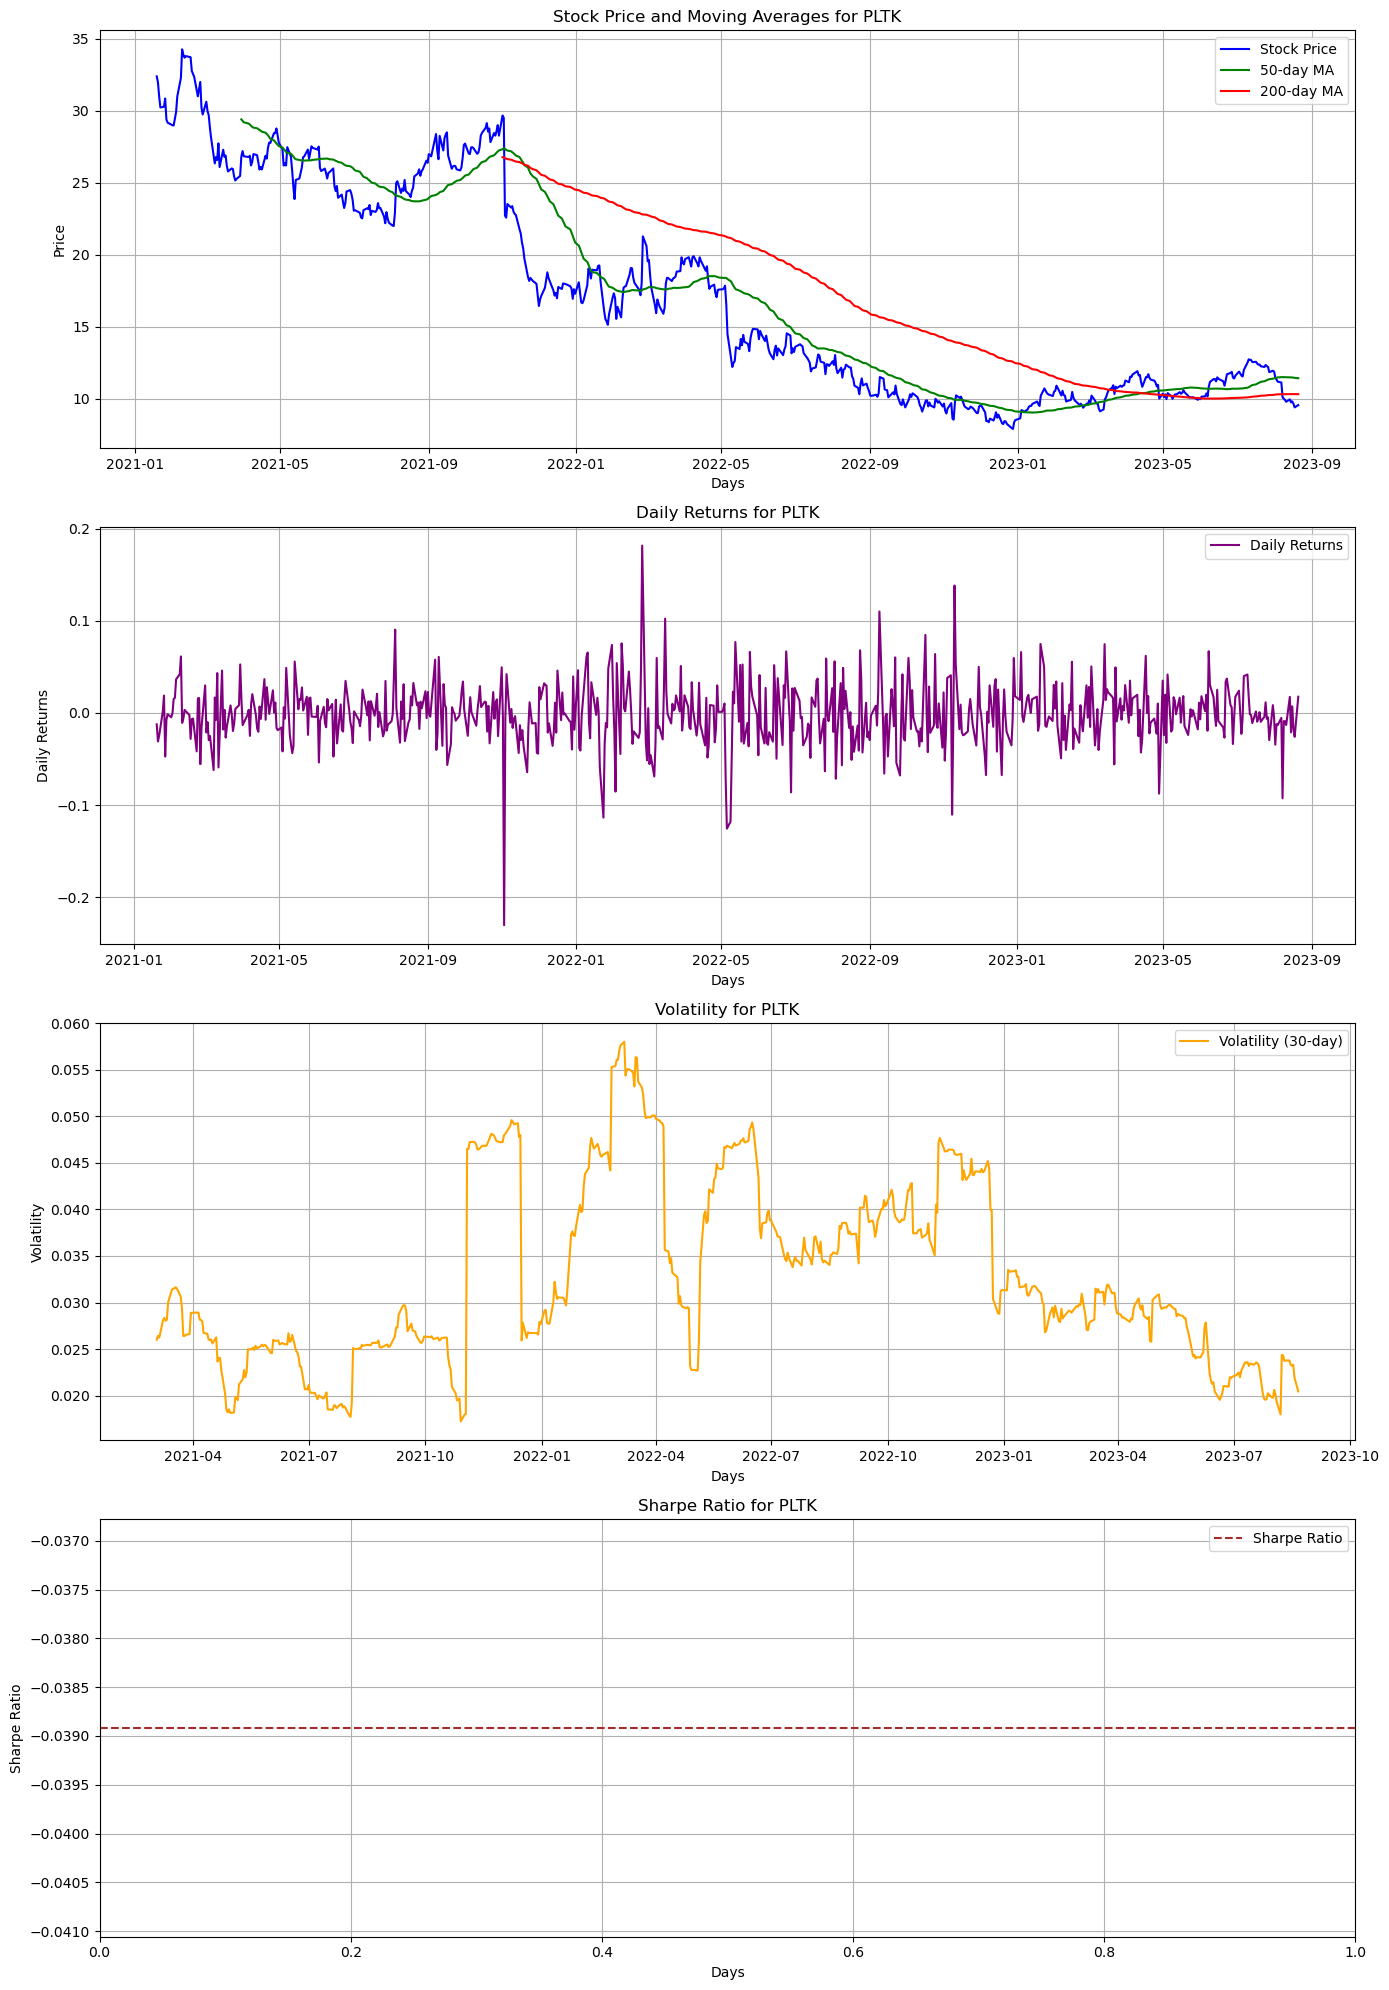

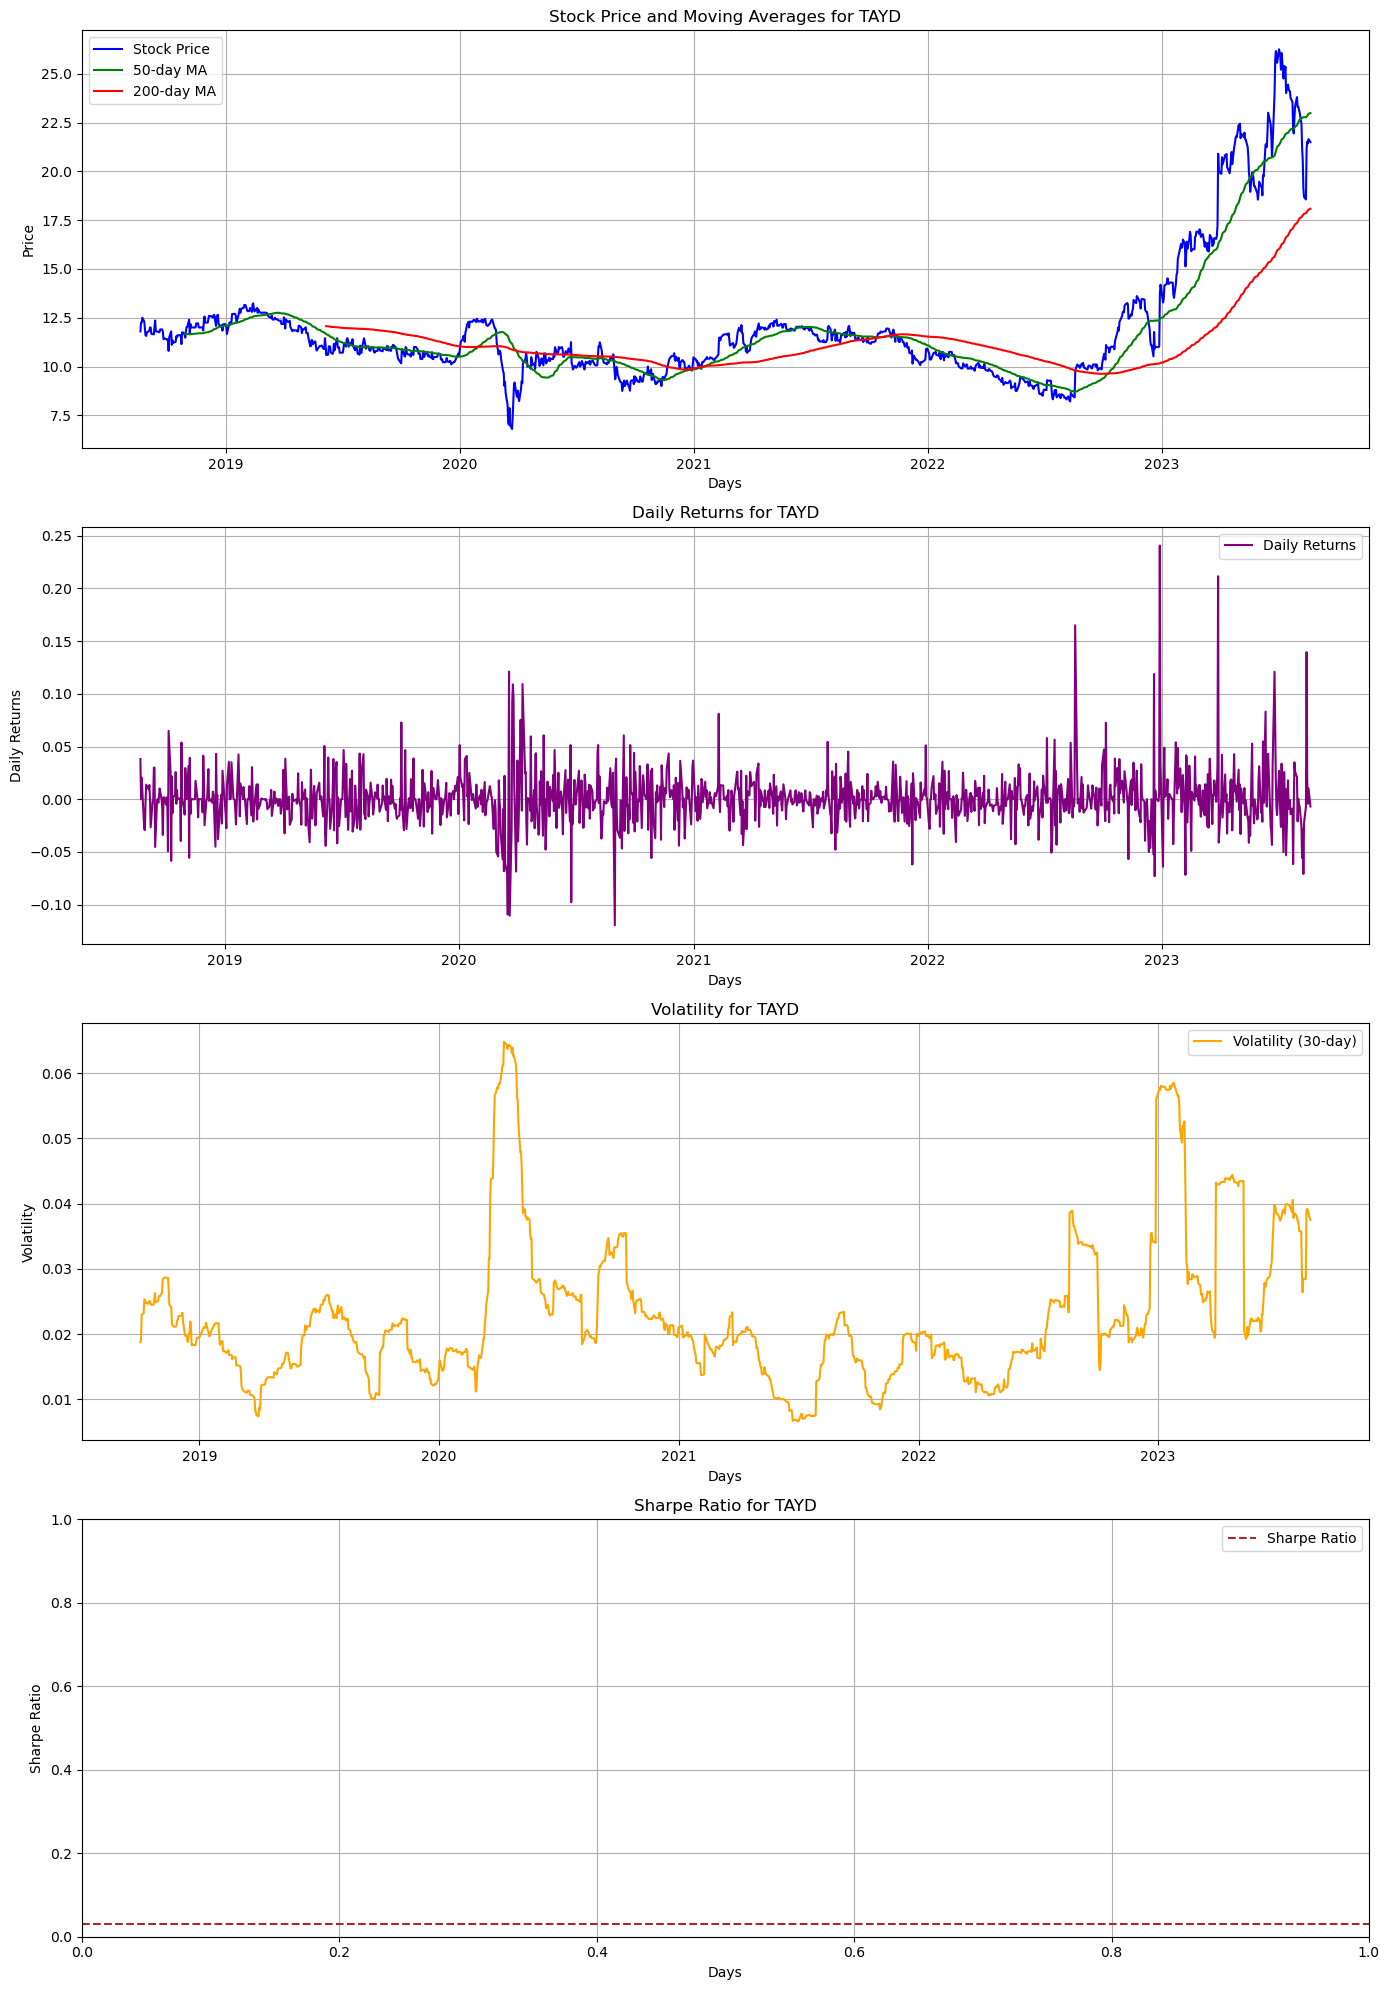

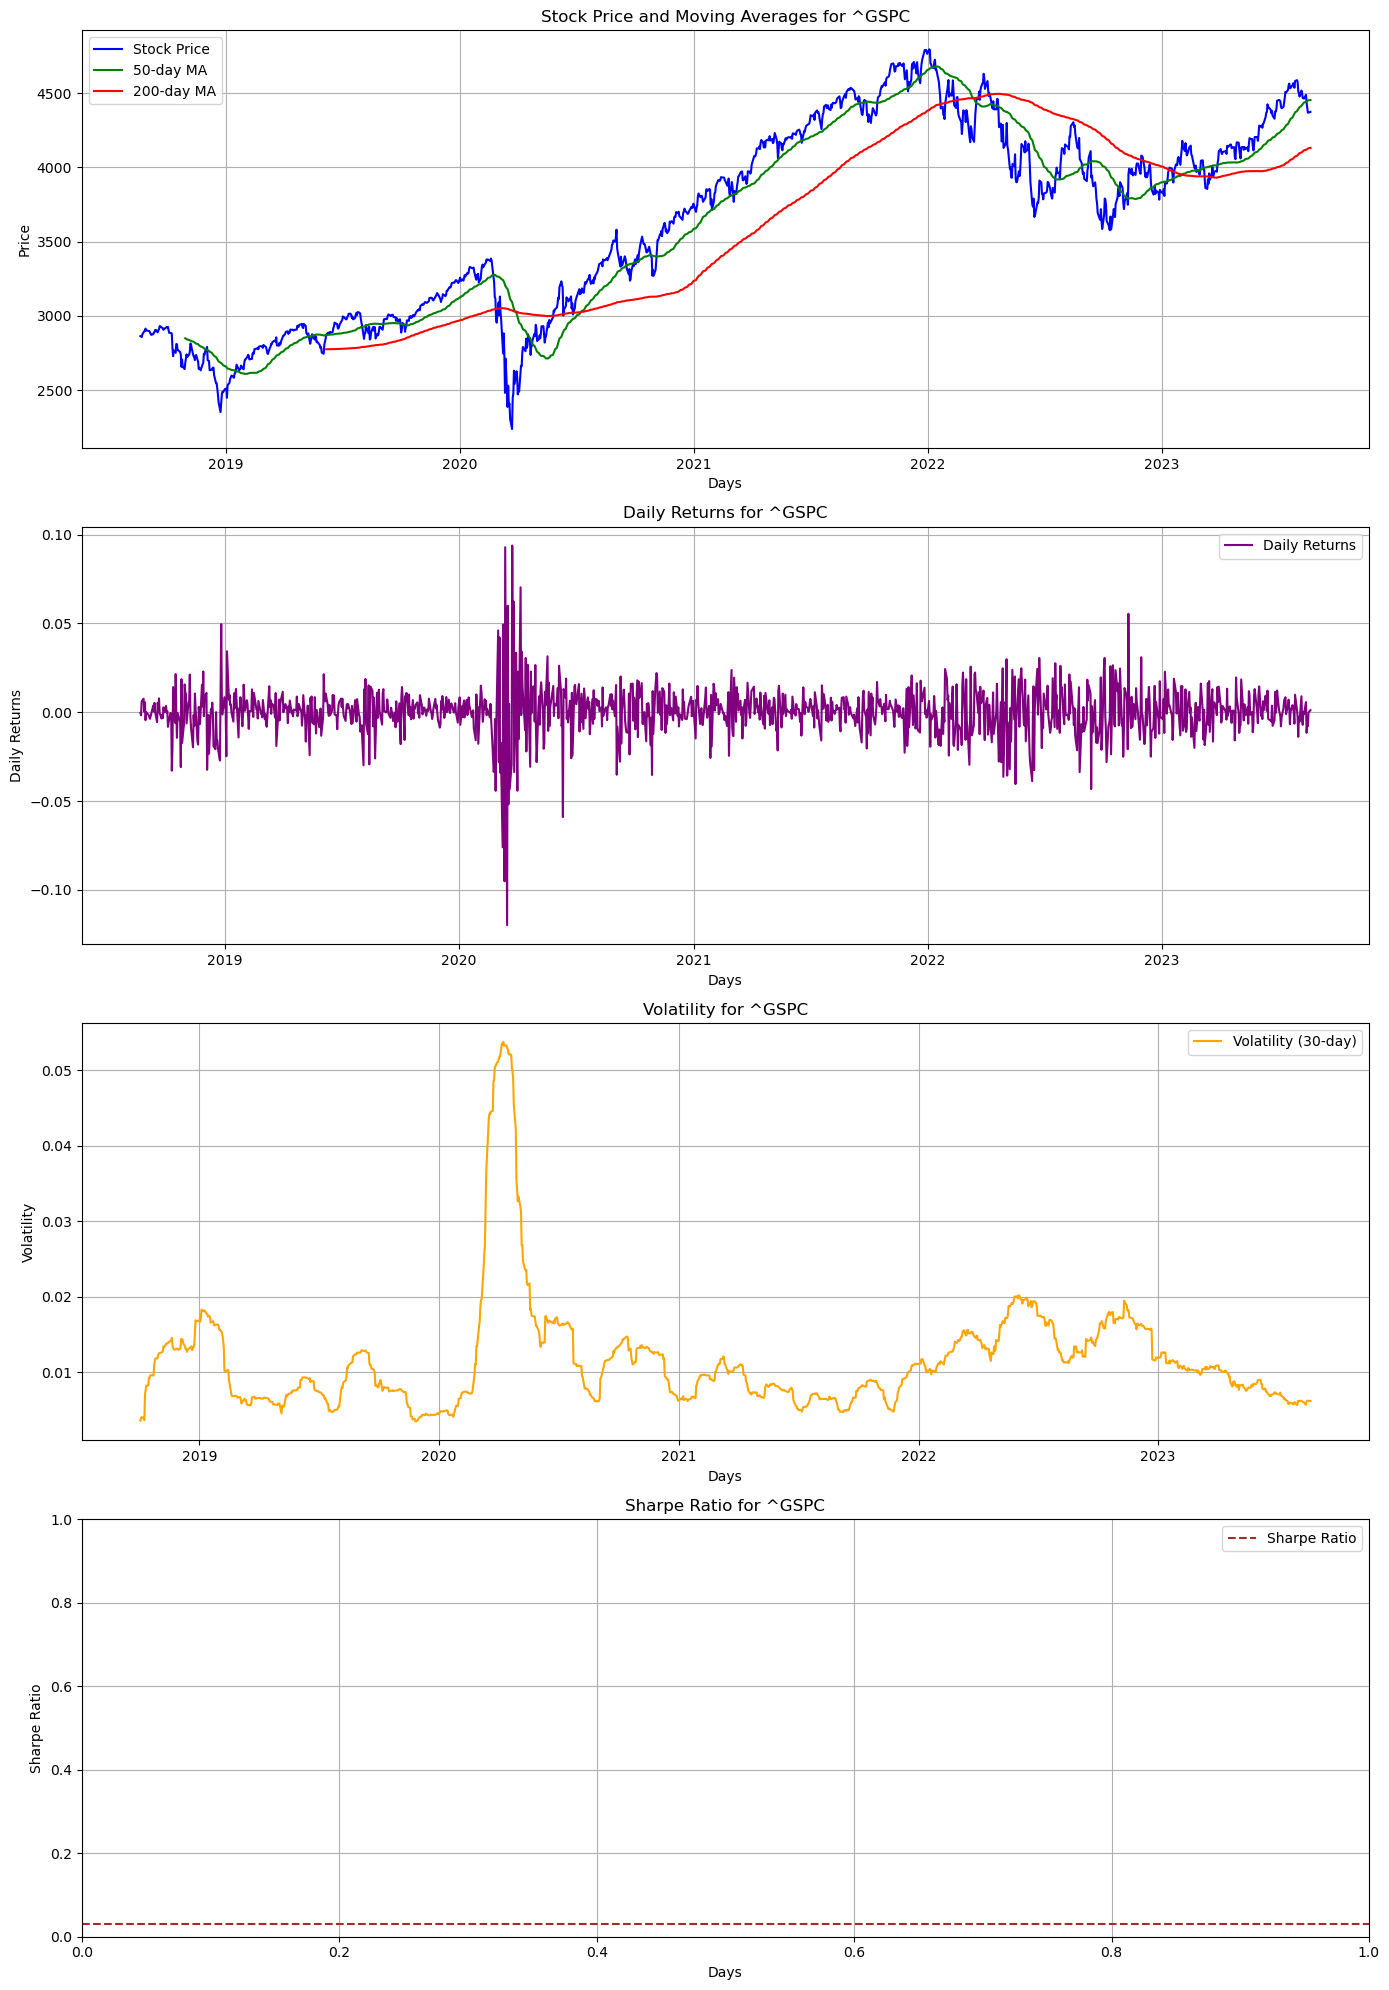

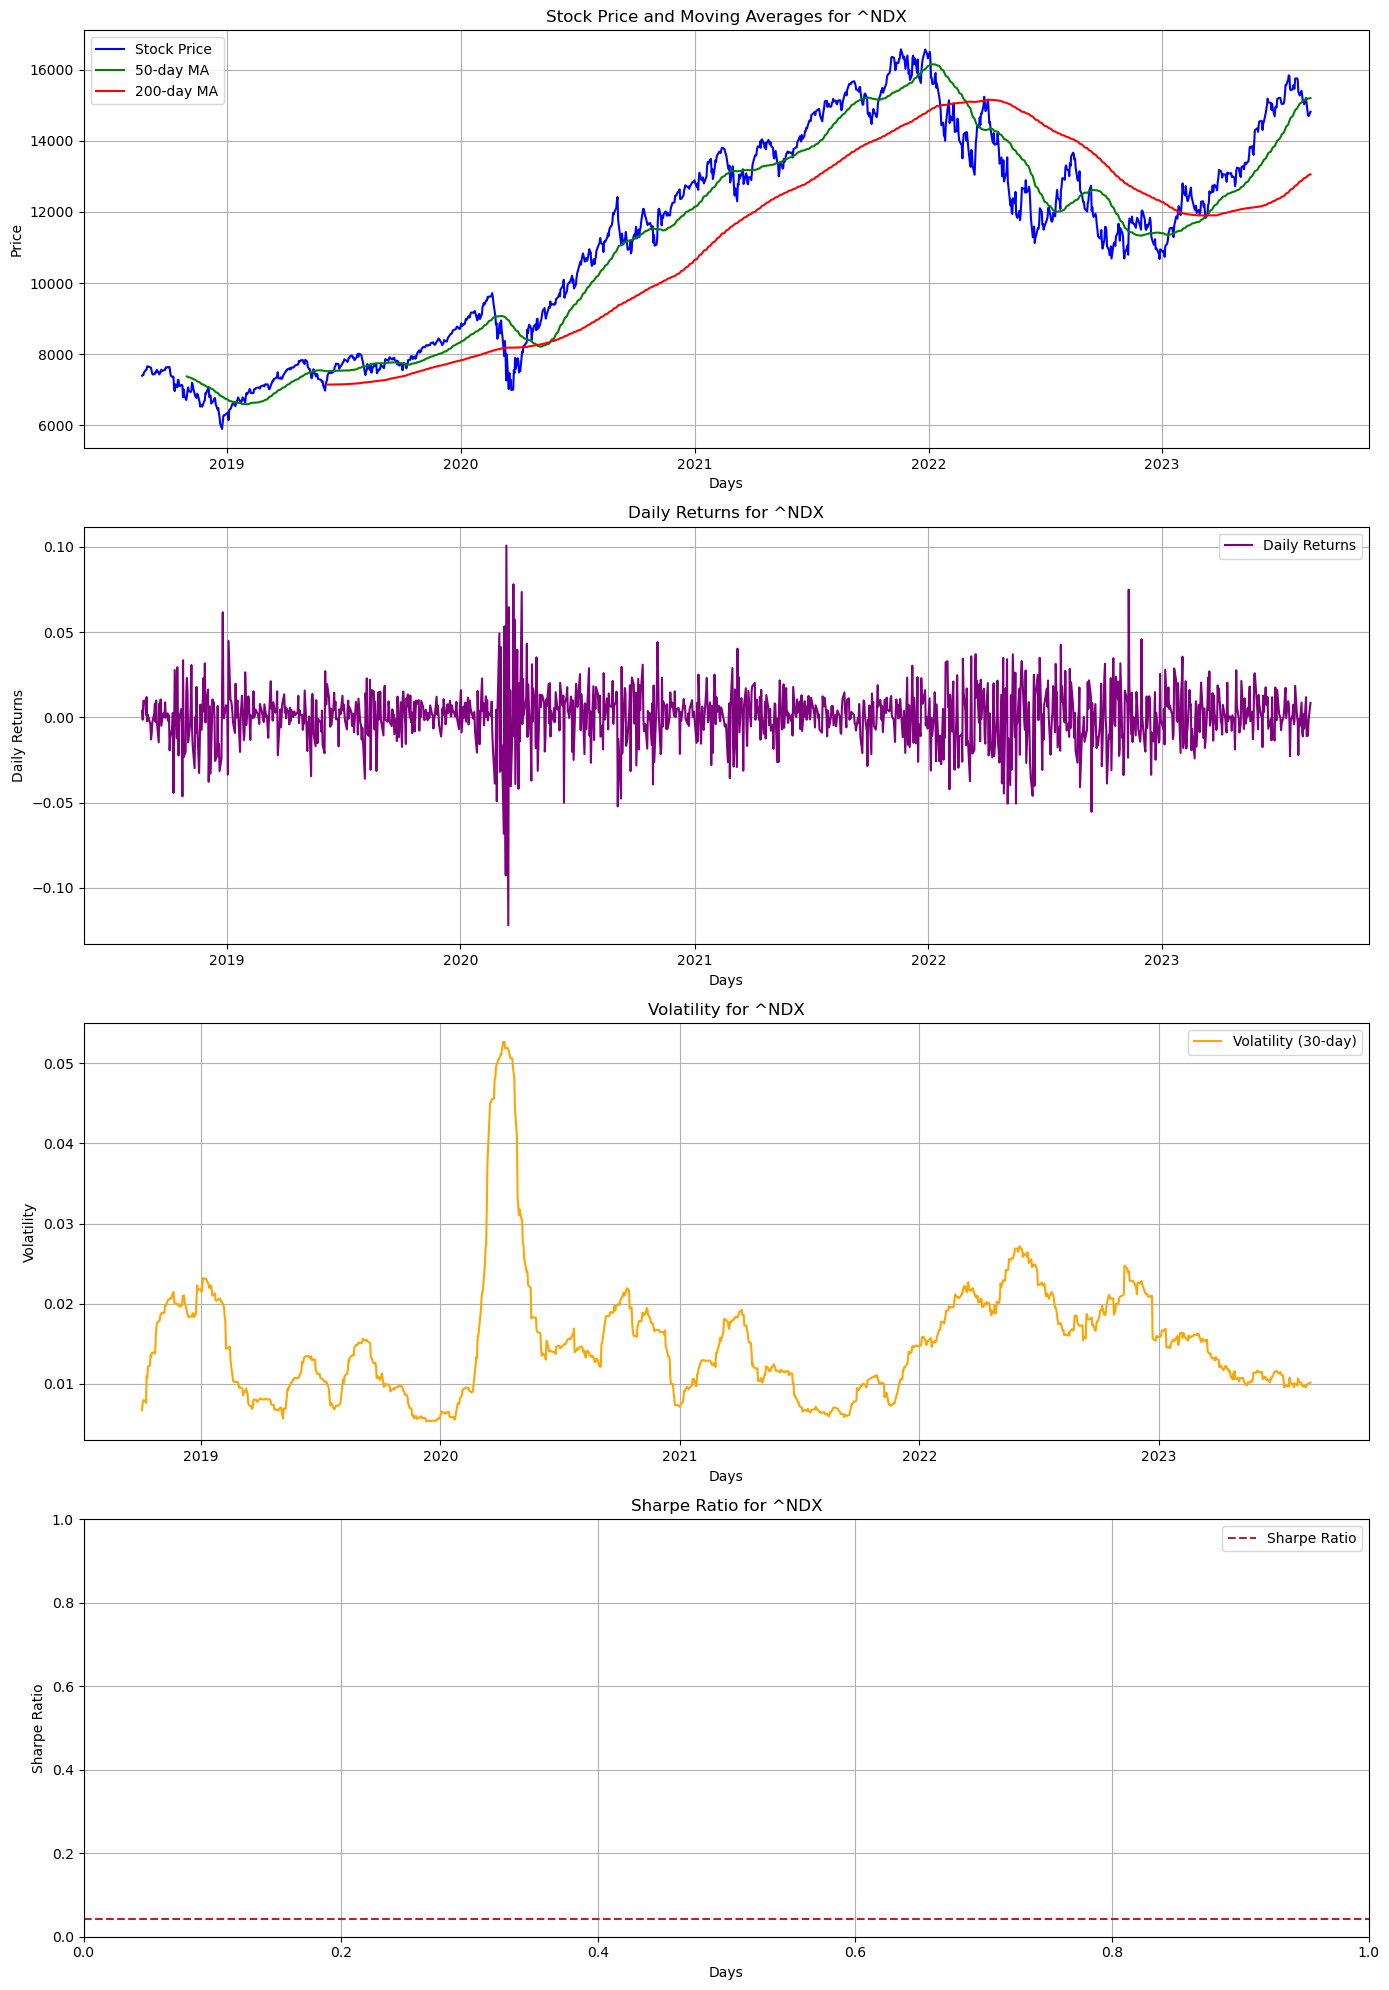

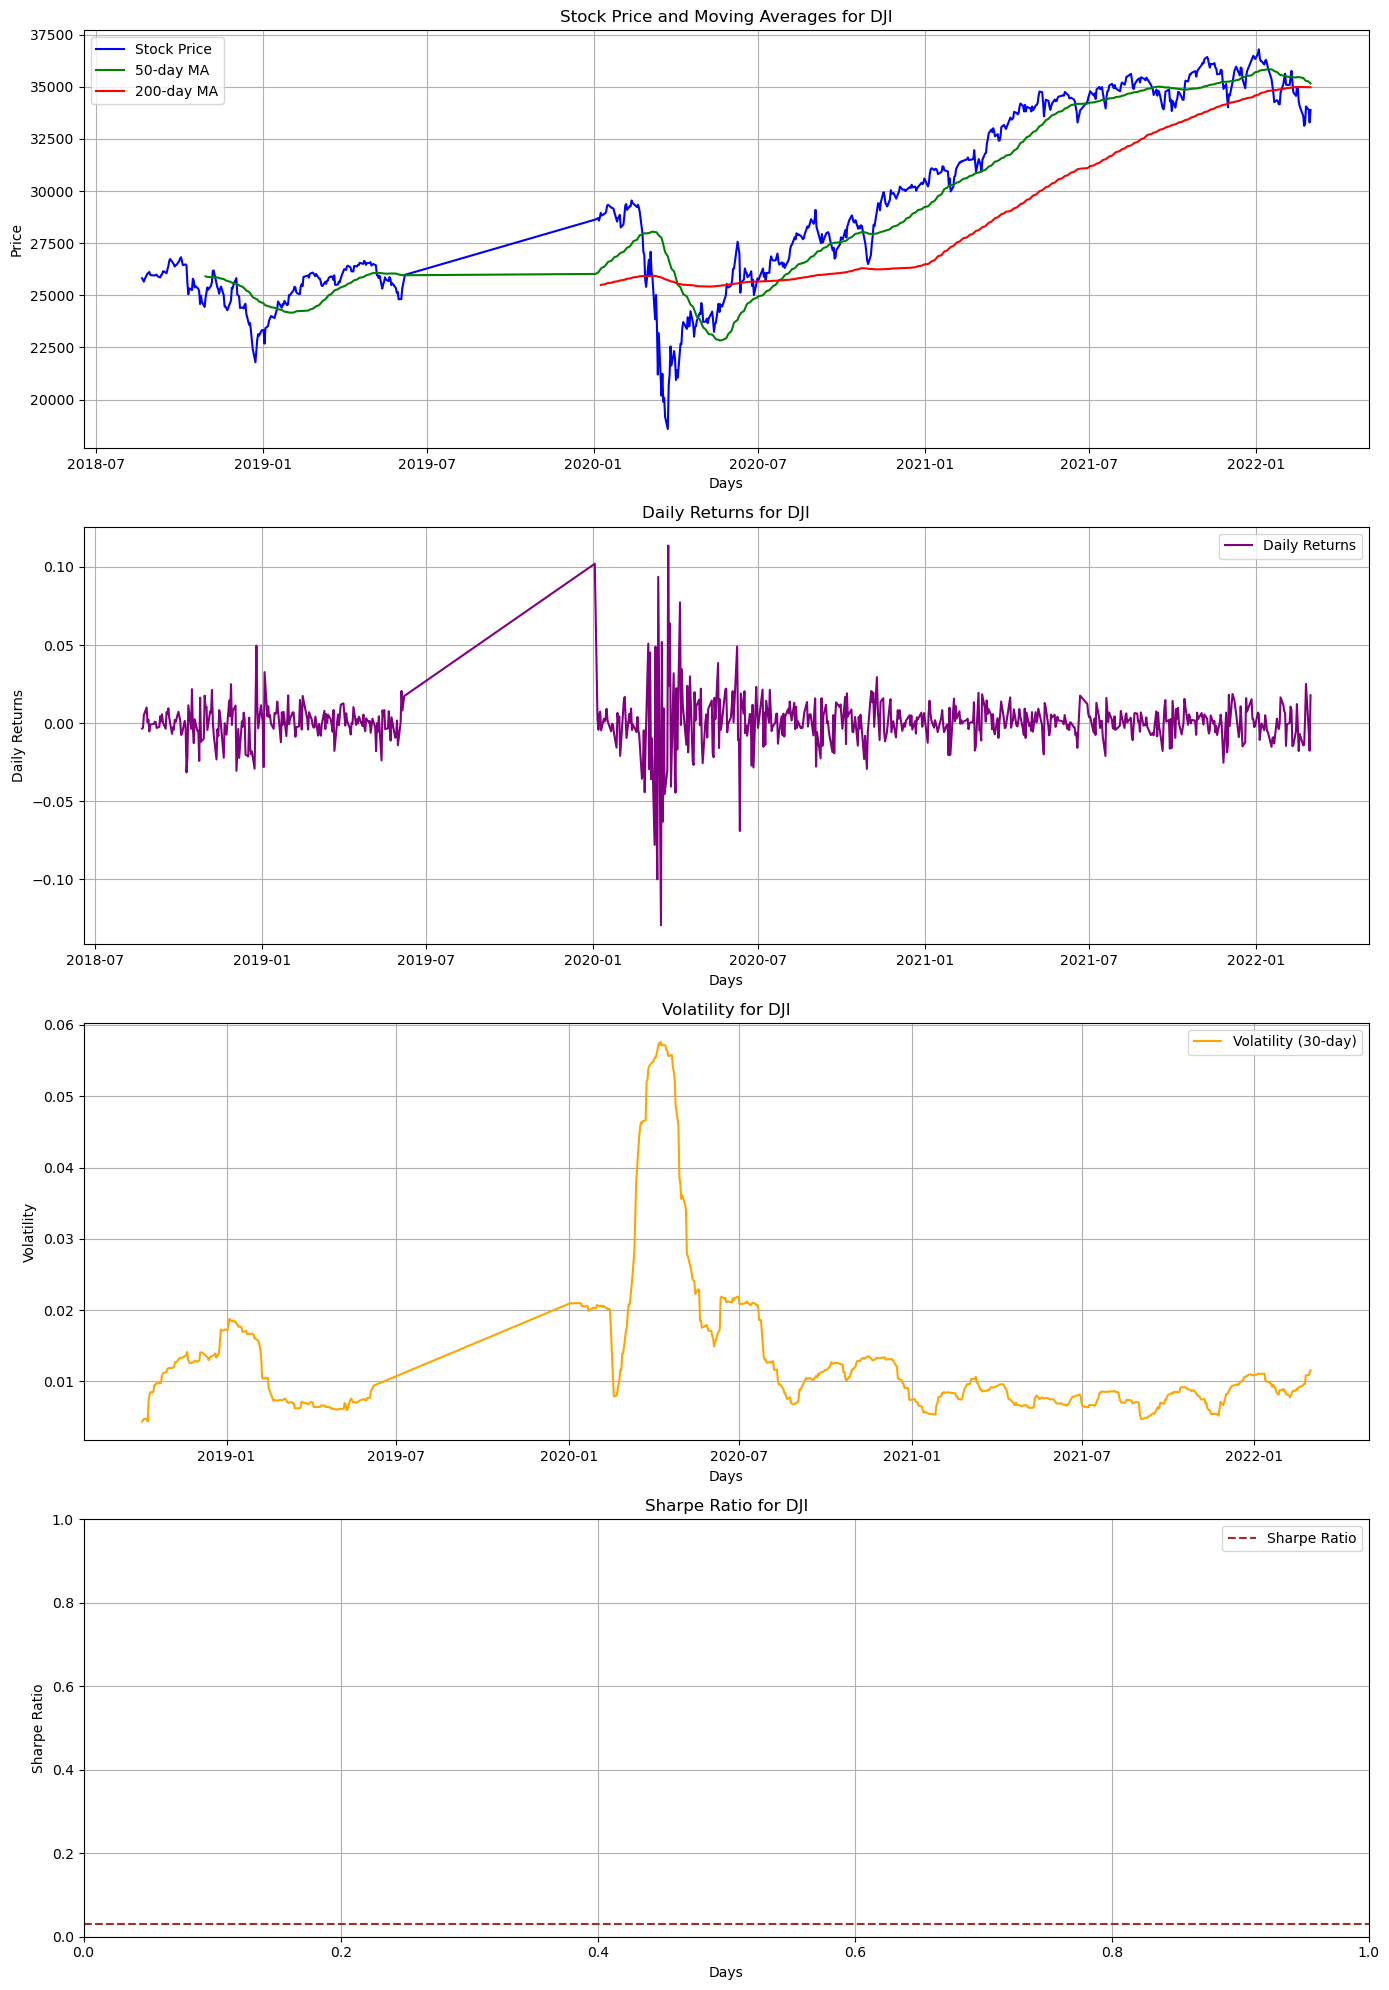

In [11]:
for ticker in tickers:
    df_temp = stock_data[stock_data["Ticker"]==ticker]
    plots(df_temp, ticker)

In [12]:
def plots_moving_averages(stock_data, ticker):   
    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(stock_data['Close'], label='Stock Price', color='blue')
    plt.plot(stock_data['50_SMA'], label='50-day SMA', color='green')
    plt.plot(stock_data['200_SMA'], label='200-day SMA', color='red')
    plt.title(f'Stock Price and Moving Averages for {ticker}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


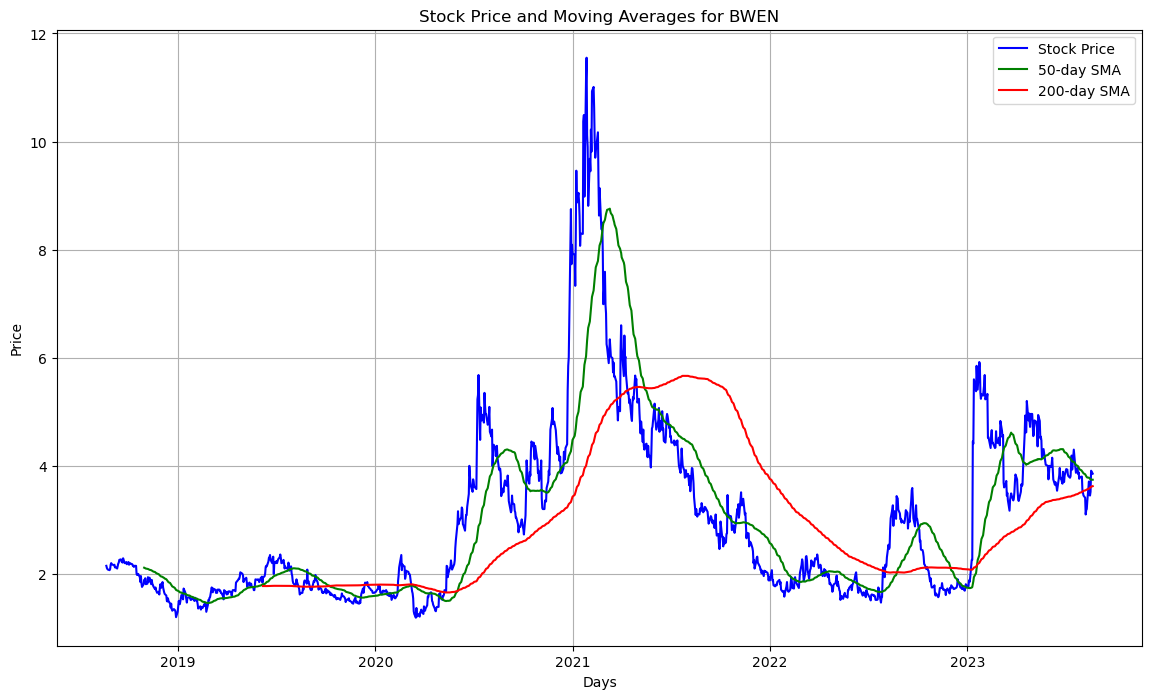

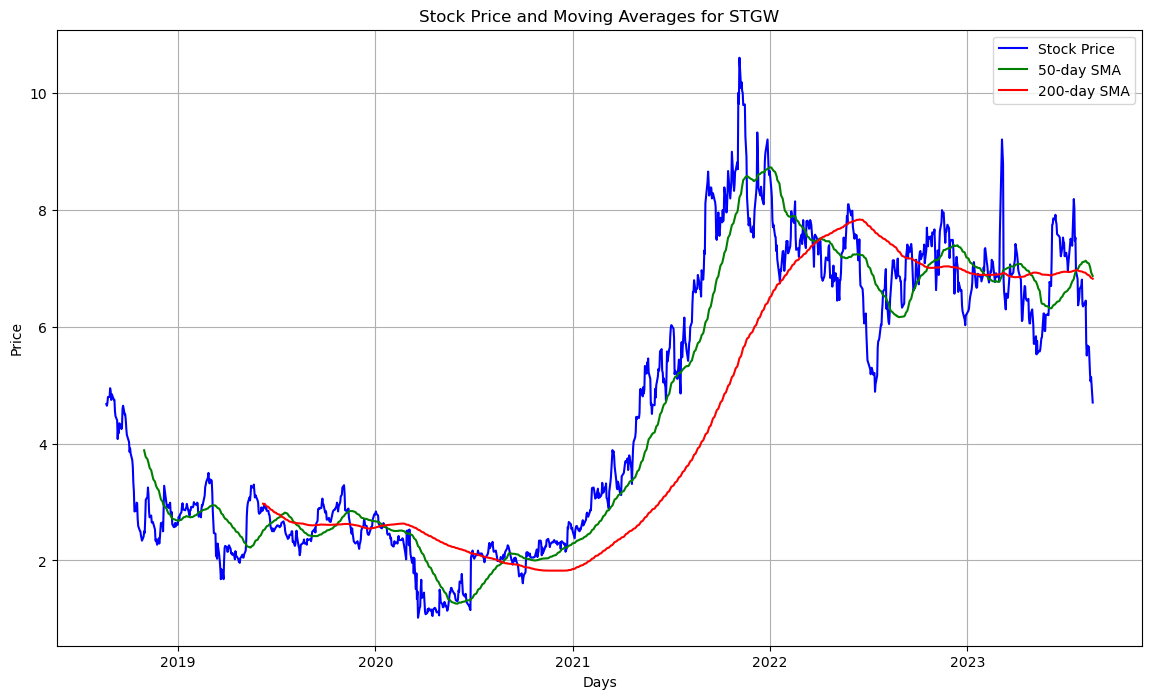

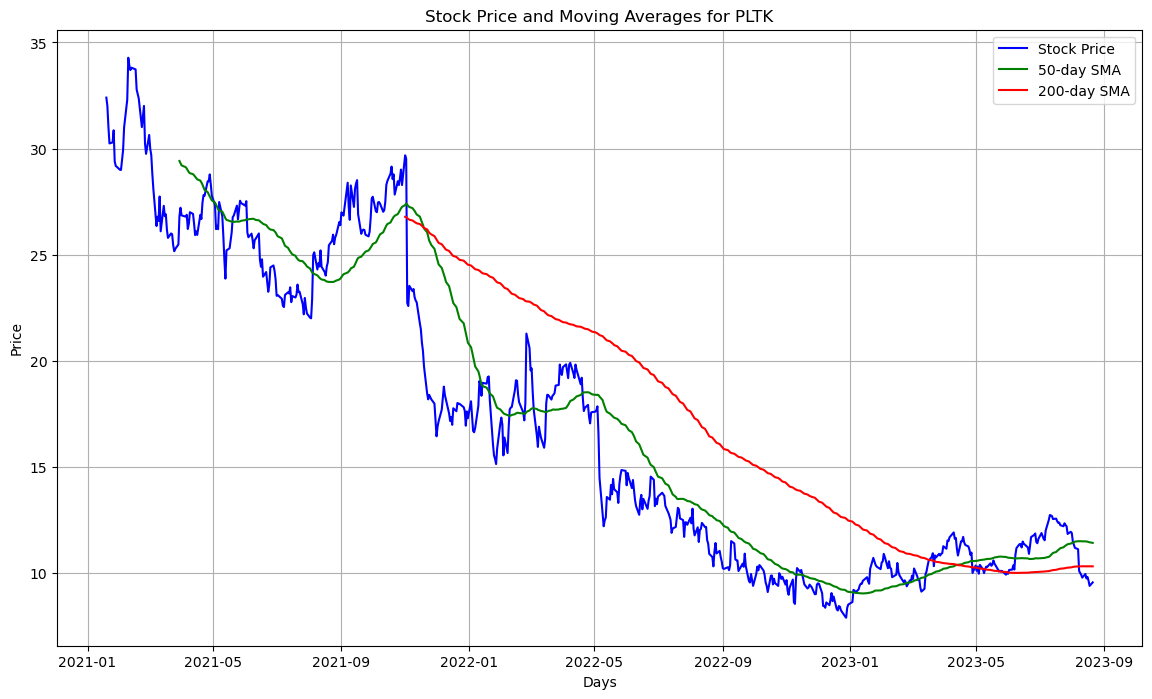

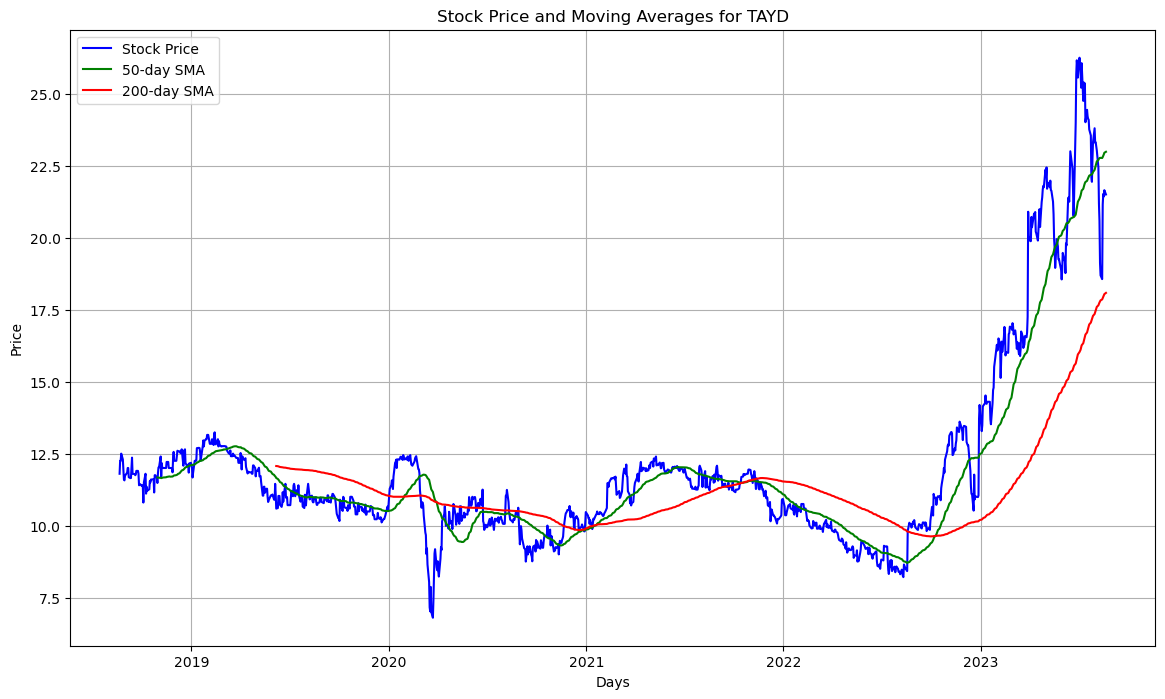

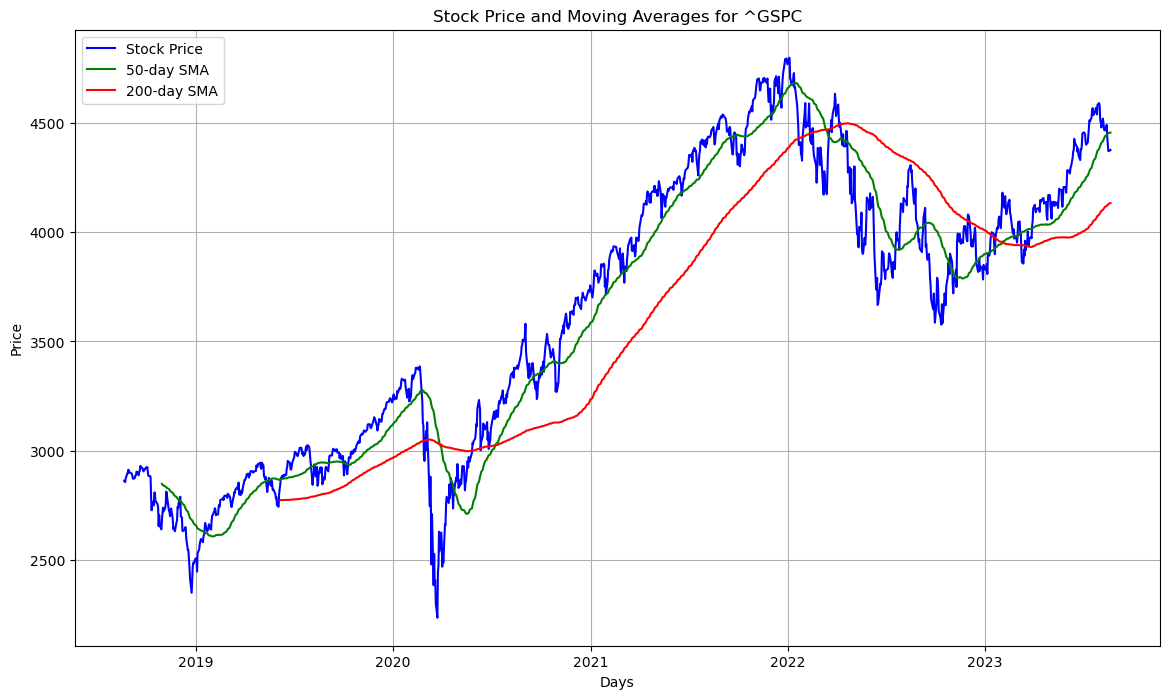

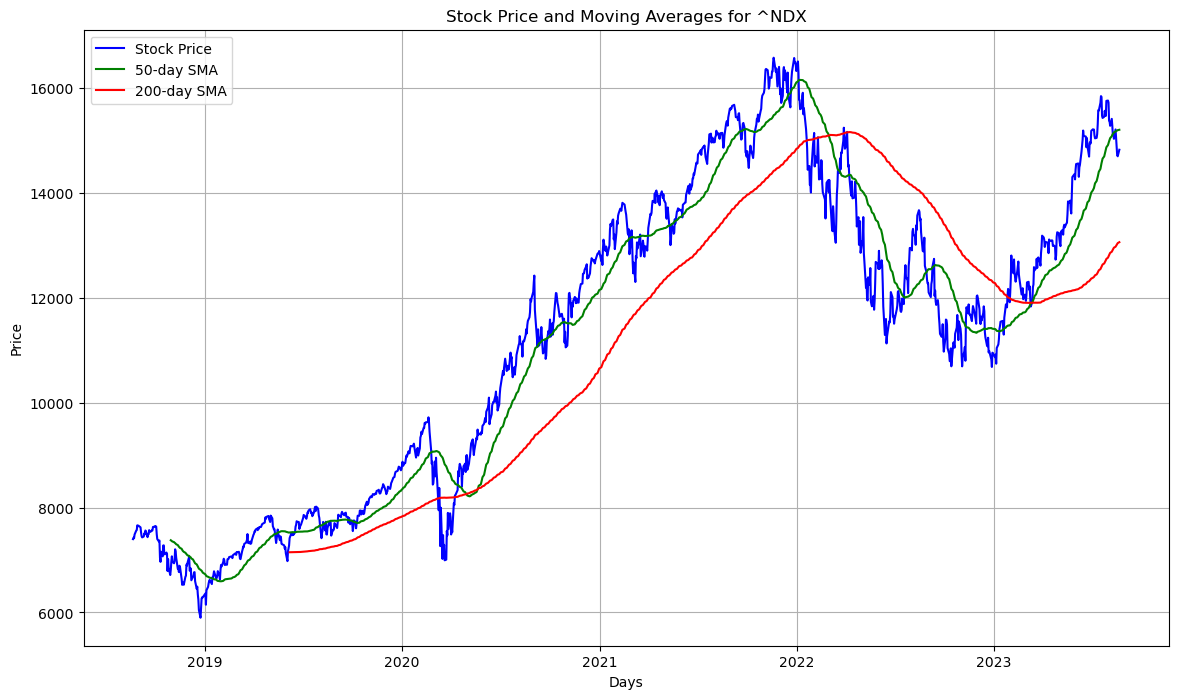

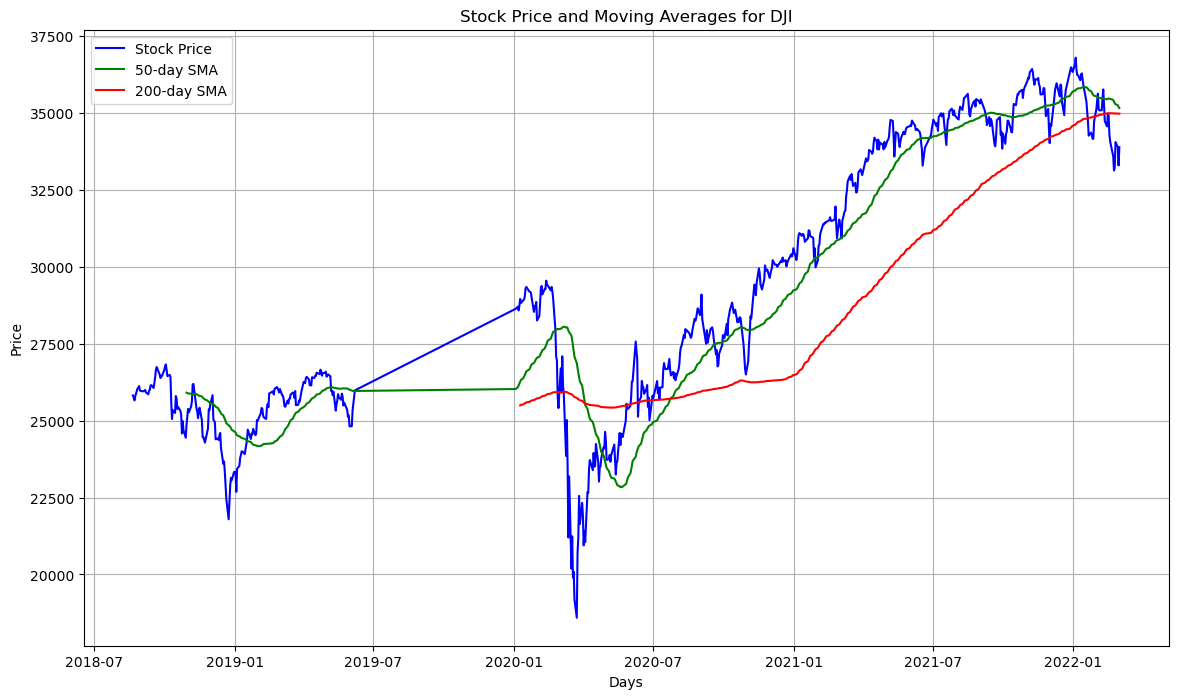

In [13]:
for ticker in tickers:
    df_temp = stock_data[stock_data["Ticker"]==ticker]
    plots_moving_averages(df_temp, ticker)

In [14]:
def momentum_indicators(stock_data):
    # Calculate RSI
    delta = stock_data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate MACD
    stock_data['12_EMA'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
    stock_data['26_EMA'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
    stock_data['MACD'] = stock_data['12_EMA'] - stock_data['26_EMA']

    # Calculate Stochastic Oscillator
    low_14 = stock_data['Close'].rolling(window=14).min()
    high_14 = stock_data['Close'].rolling(window=14).max()
    stock_data['Stochastic_Oscillator'] = 100 * (stock_data['Close'] - low_14) / (high_14 - low_14)
    
    return stock_data

In [15]:
df = pd.DataFrame()
for ticker in tickers:
    df_temp = stock_data[stock_data["Ticker"]==ticker]
    df_temp = momentum_indicators(df_temp)
    df = df.append(df_temp)
    
stock_data = df

/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/1487074525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['RSI'] = 100 - (100 / (1 + rs))
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/1487074525.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['12_EMA'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/1487074525.py:11: SettingWithCopyWarning: 
A value is trying to be set on

In [16]:
def plots_momentum_indicators(stock_data, ticker):
    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 20))

    # Plot stock prices
    ax1.plot(stock_data['Close'], label='Stock Price', color='blue')
    ax1.set_title(f'Stock Price for {ticker}')
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # Plot RSI
    ax2.plot(stock_data['RSI'], label='RSI', color='purple')
    ax2.axhline(70, color='red', linestyle='--')
    ax2.axhline(30, color='green', linestyle='--')
    ax2.set_title(f'Relative Strength Index (RSI) for {ticker}')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('RSI')
    ax2.legend()
    ax2.grid(True)

    # Plot MACD
    ax3.plot(stock_data['MACD'], label='MACD', color='orange')
    ax3.axhline(0, color='black', linestyle='--')
    ax3.set_title(f'Moving Average Convergence Divergence (MACD) for {ticker}')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('MACD')
    ax3.legend()
    ax3.grid(True)

    # Plot Stochastic Oscillator
    ax4.plot(stock_data['Stochastic_Oscillator'], label='Stochastic Oscillator', color='brown')
    ax4.axhline(80, color='red', linestyle='--')
    ax4.axhline(20, color='green', linestyle='--')
    ax4.set_title(f'Stochastic Oscillator for {ticker}')
    ax4.set_xlabel('Days')
    ax4.set_ylabel('Stochastic Oscillator')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

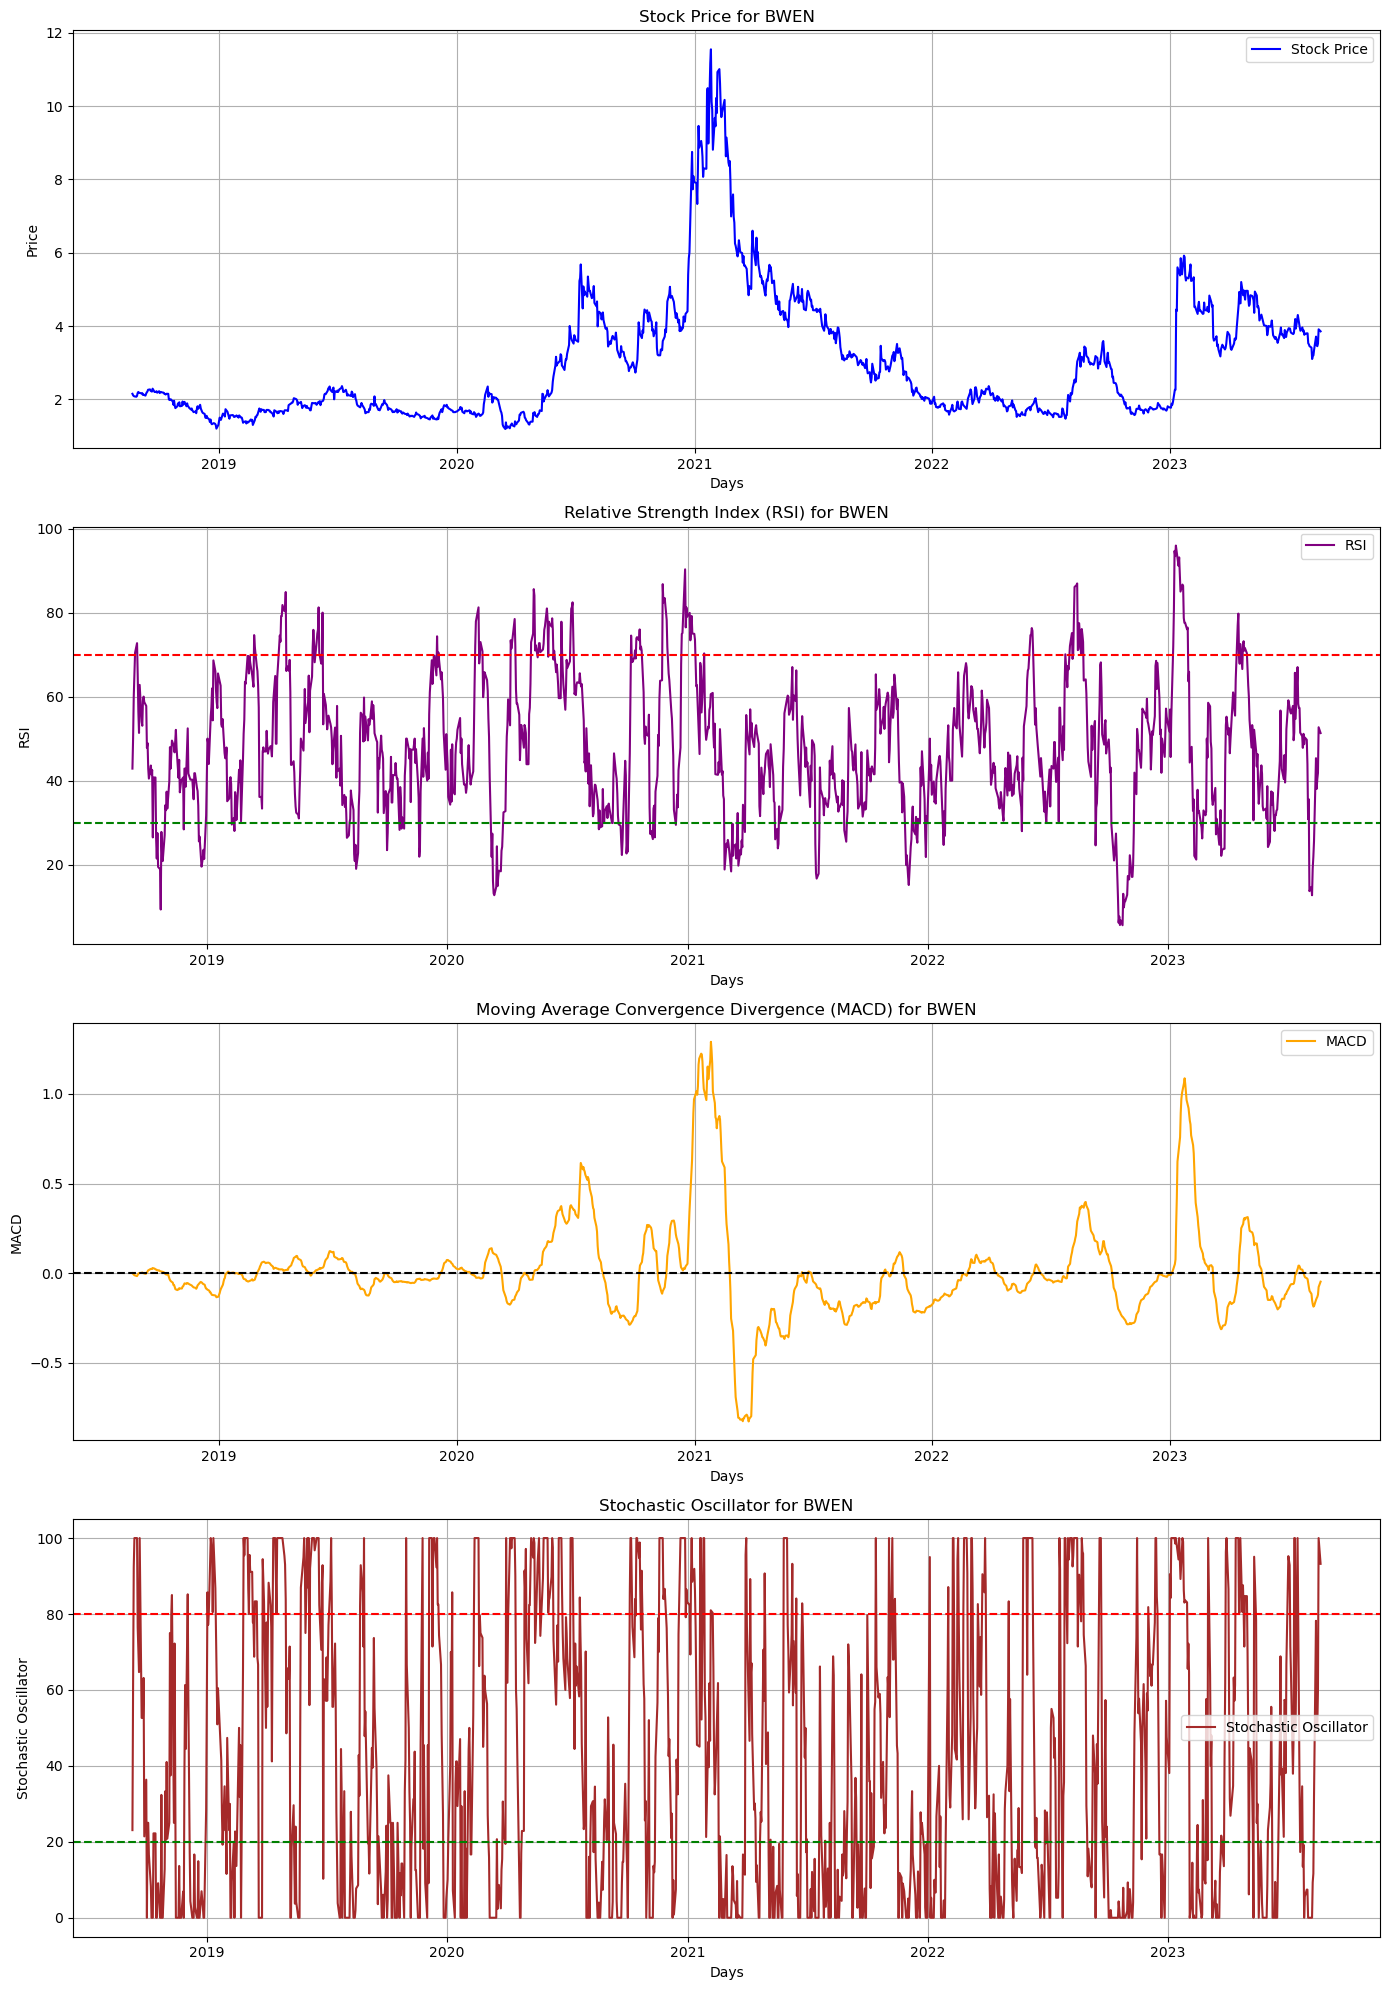

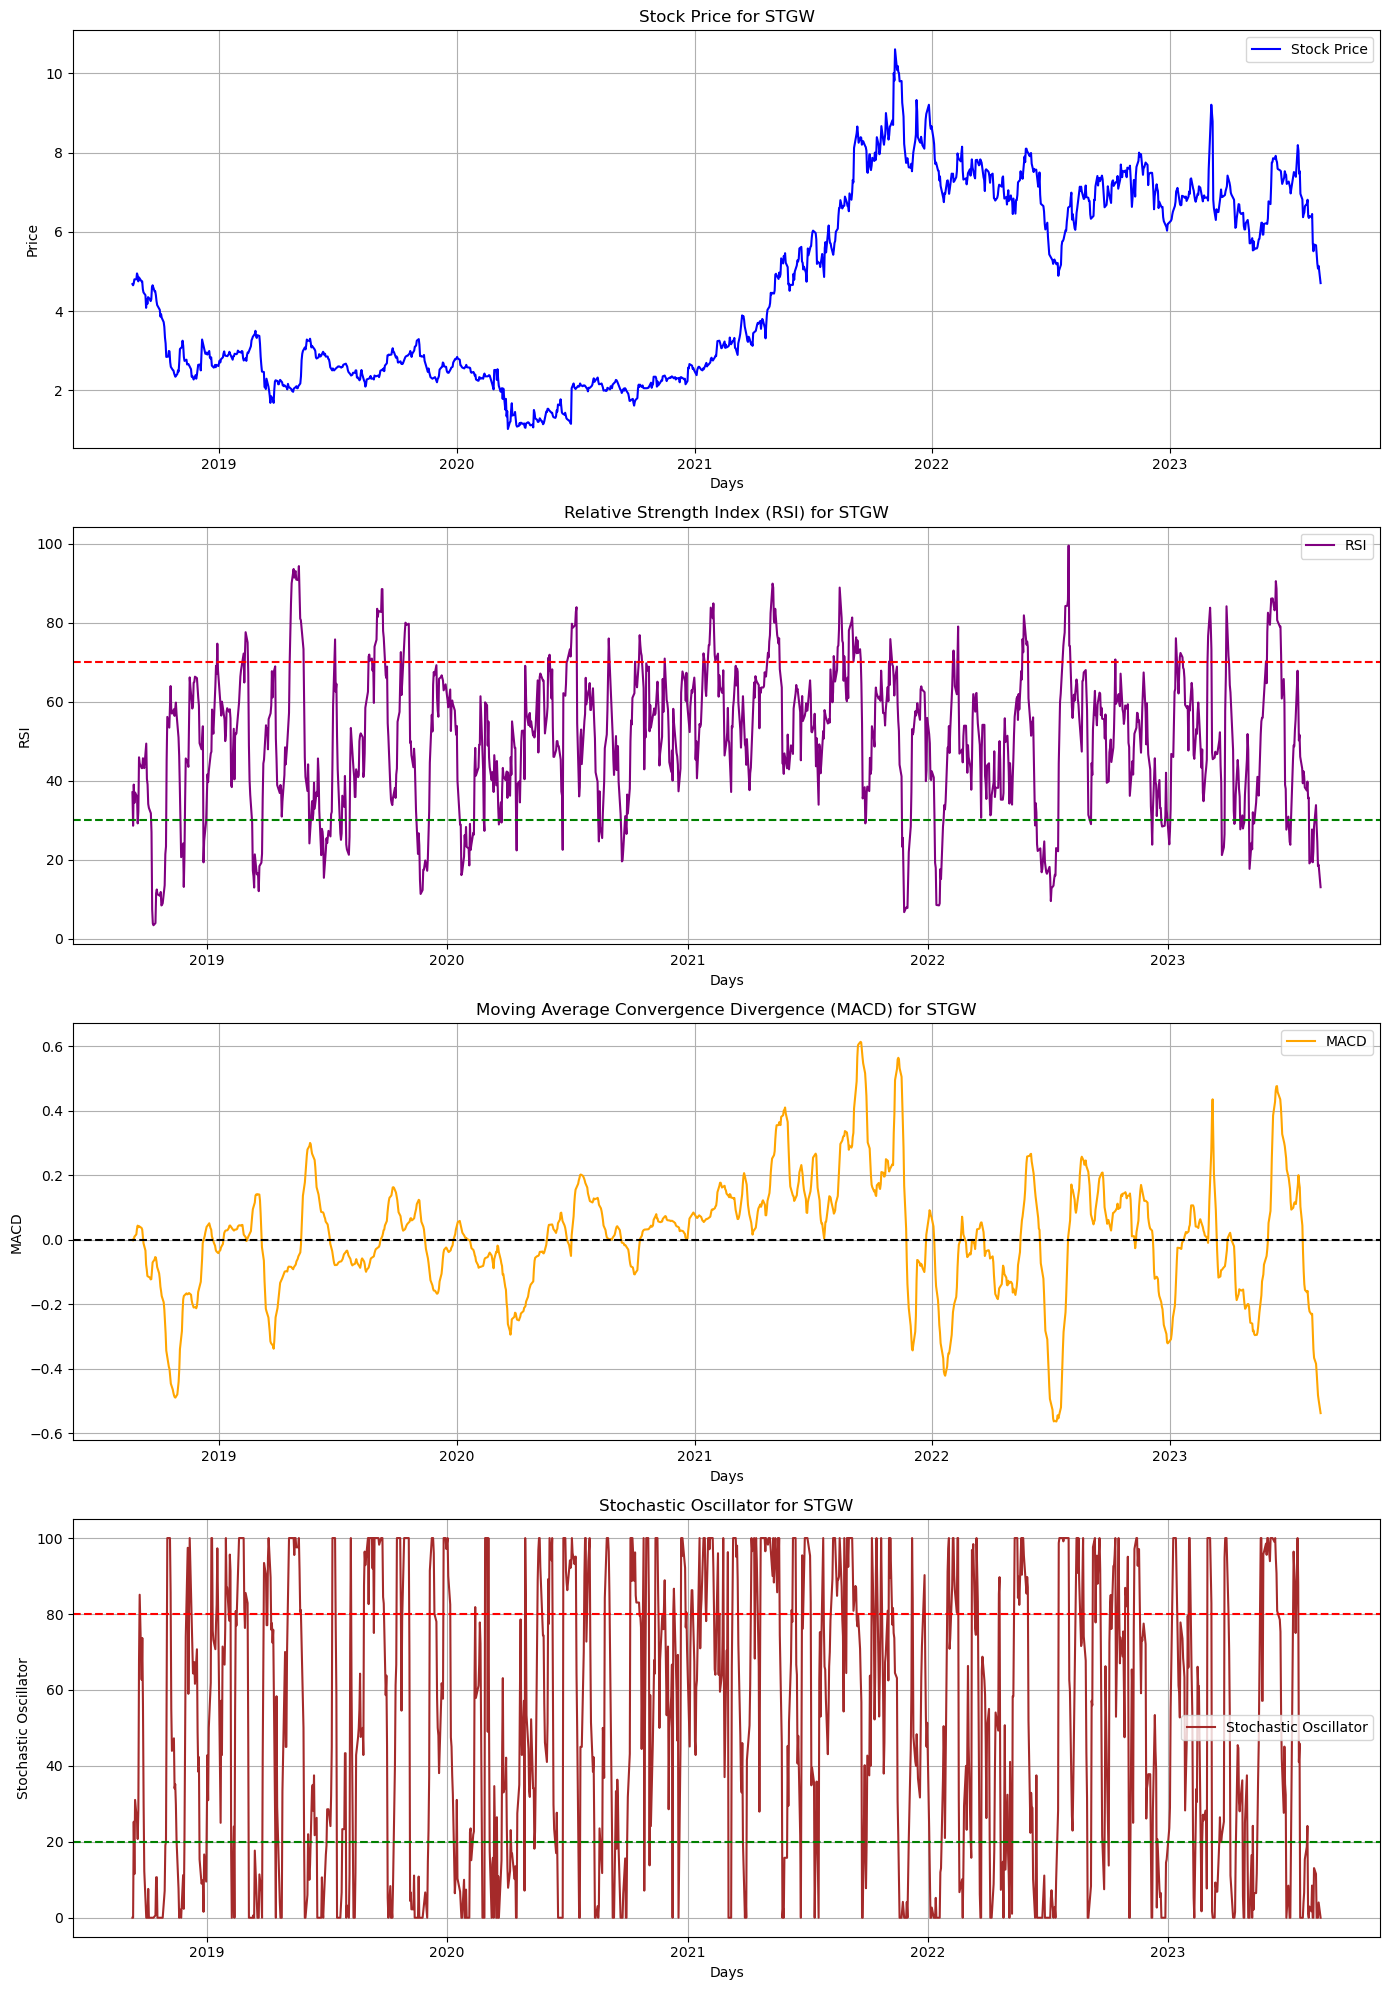

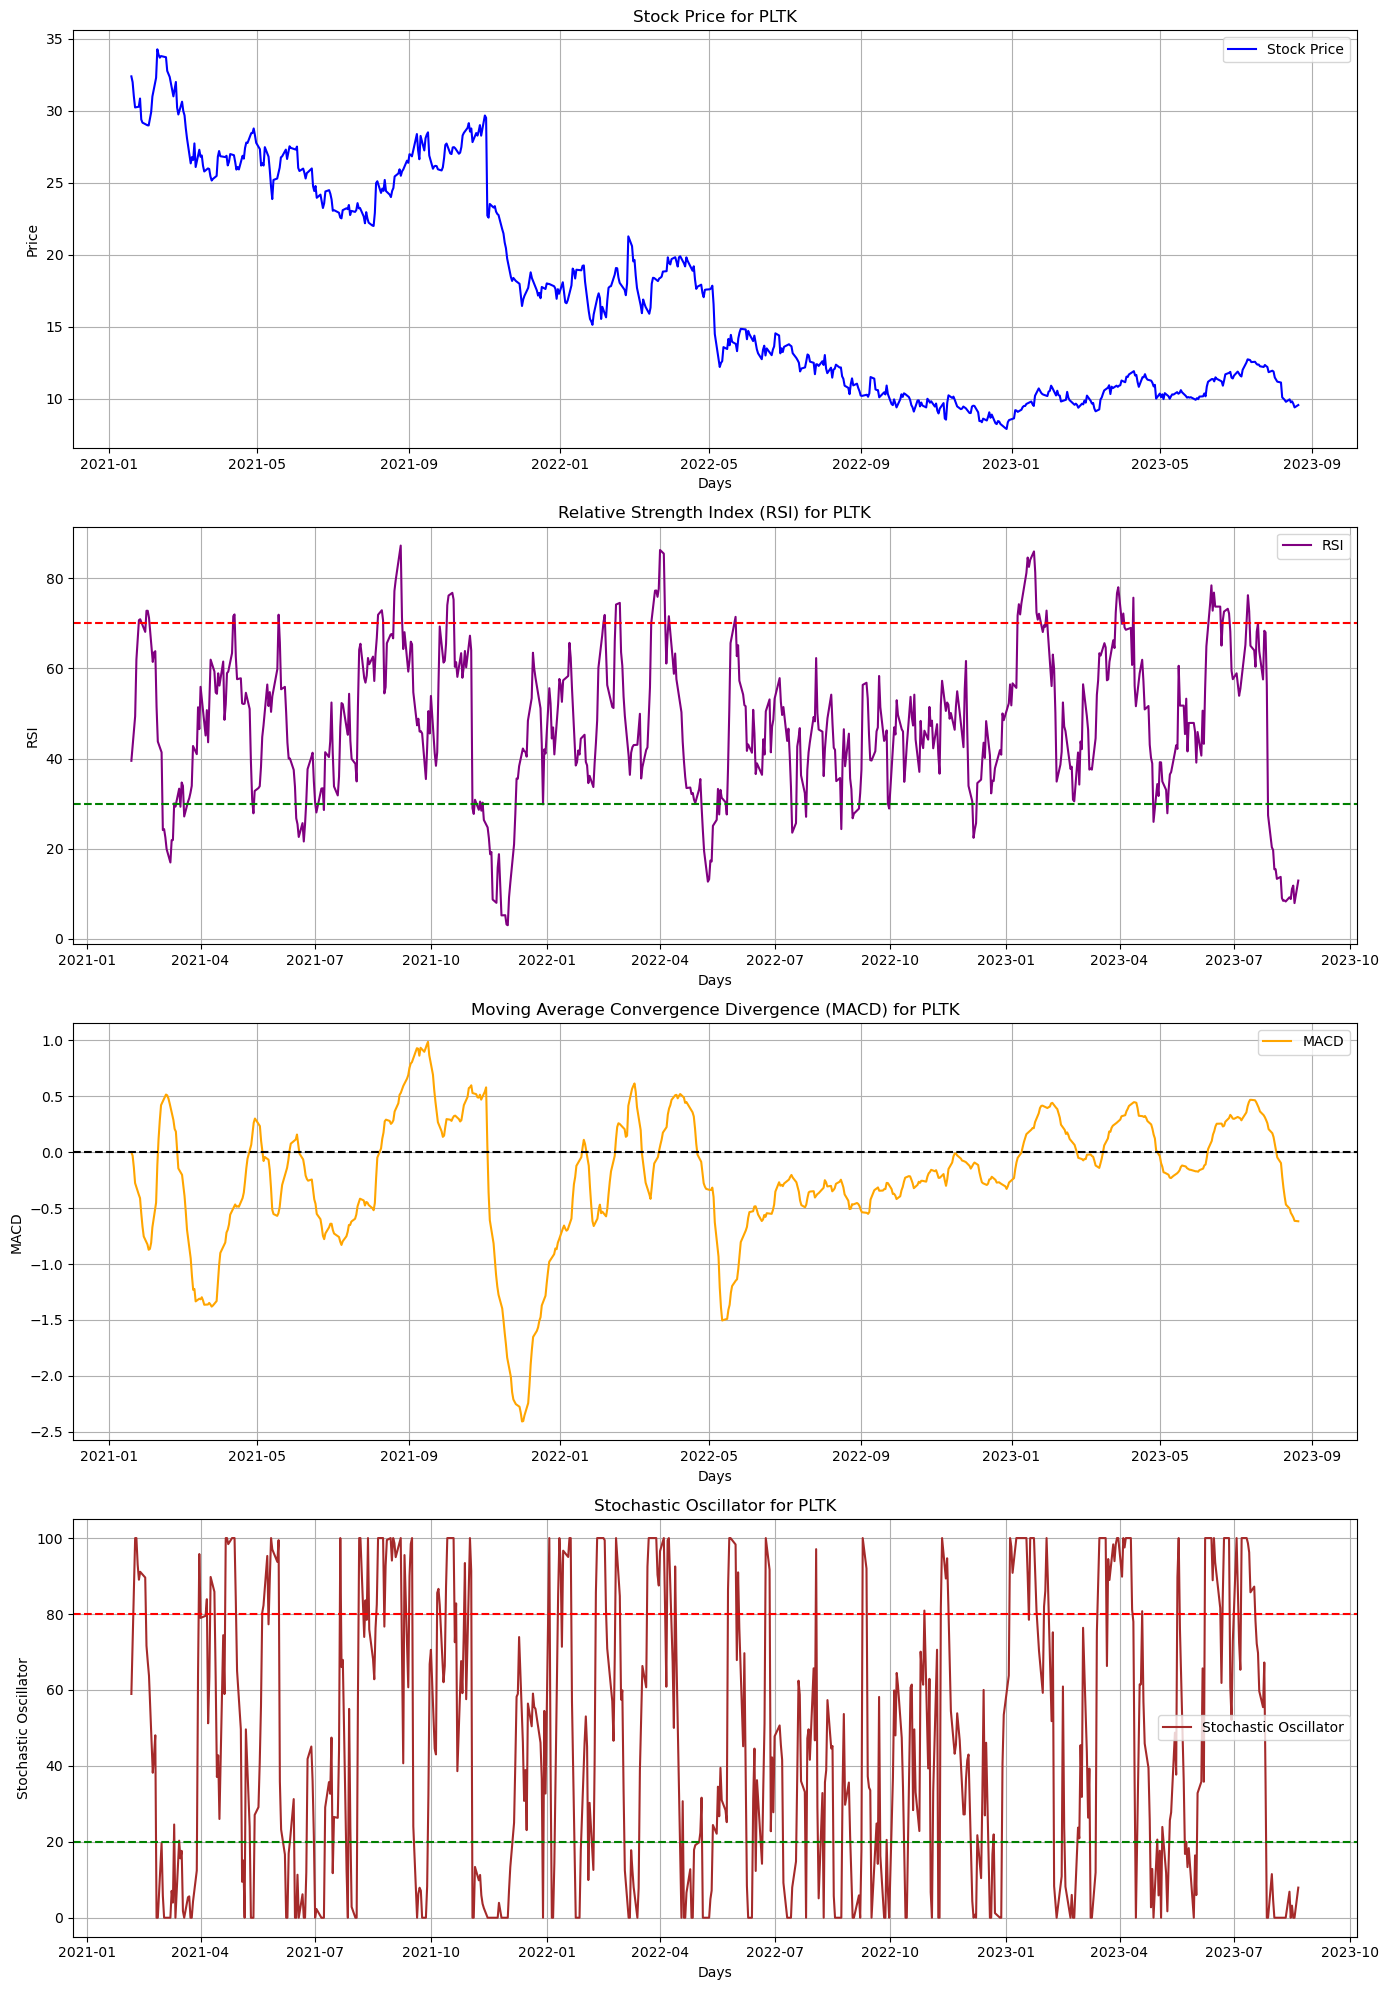

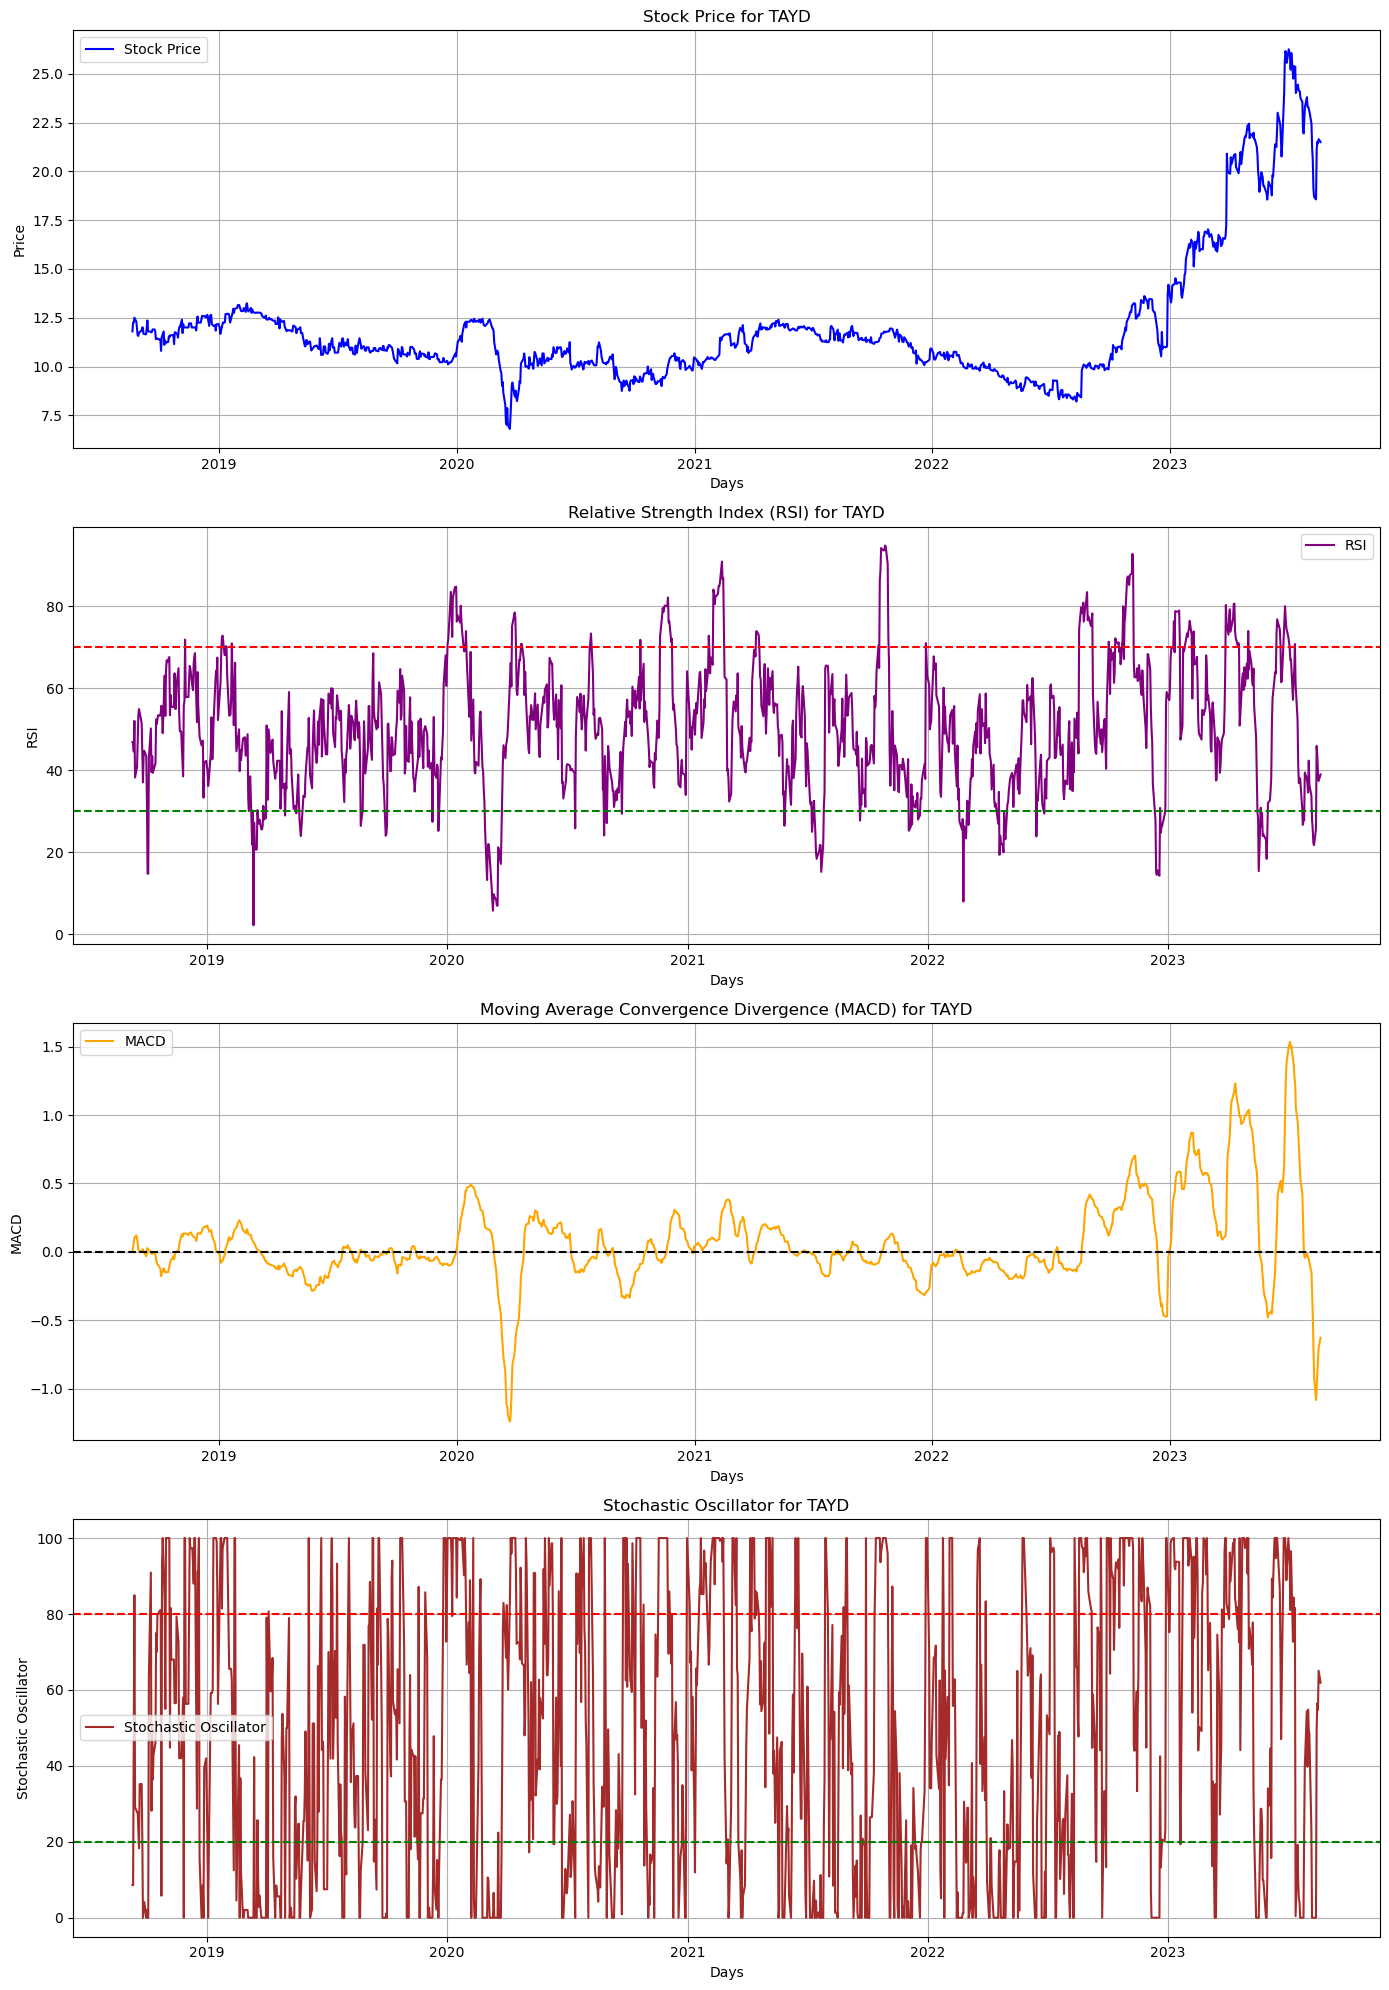

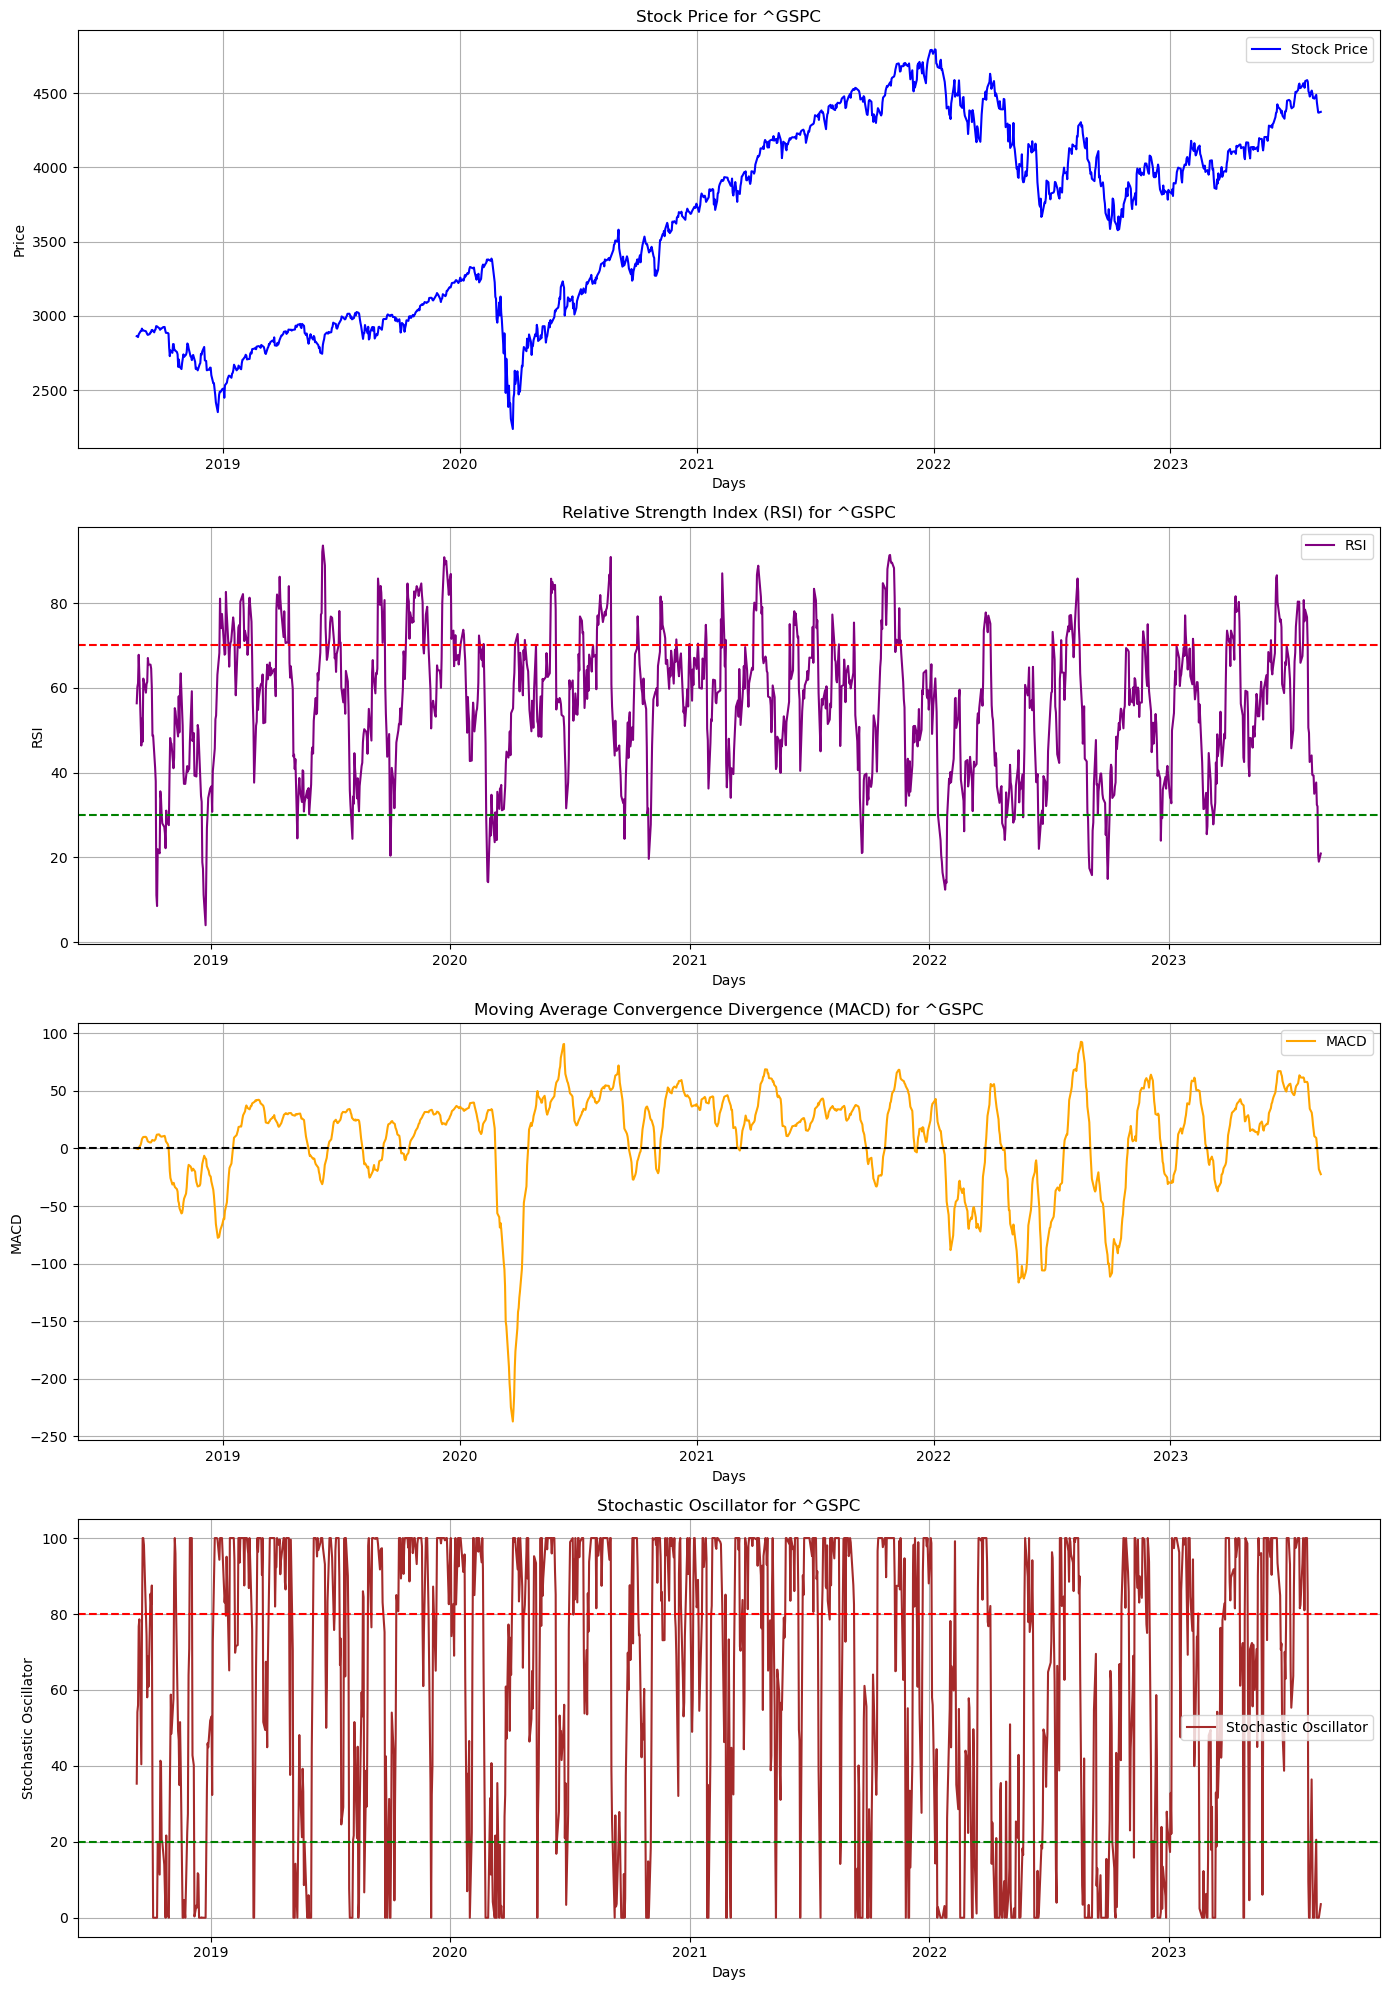

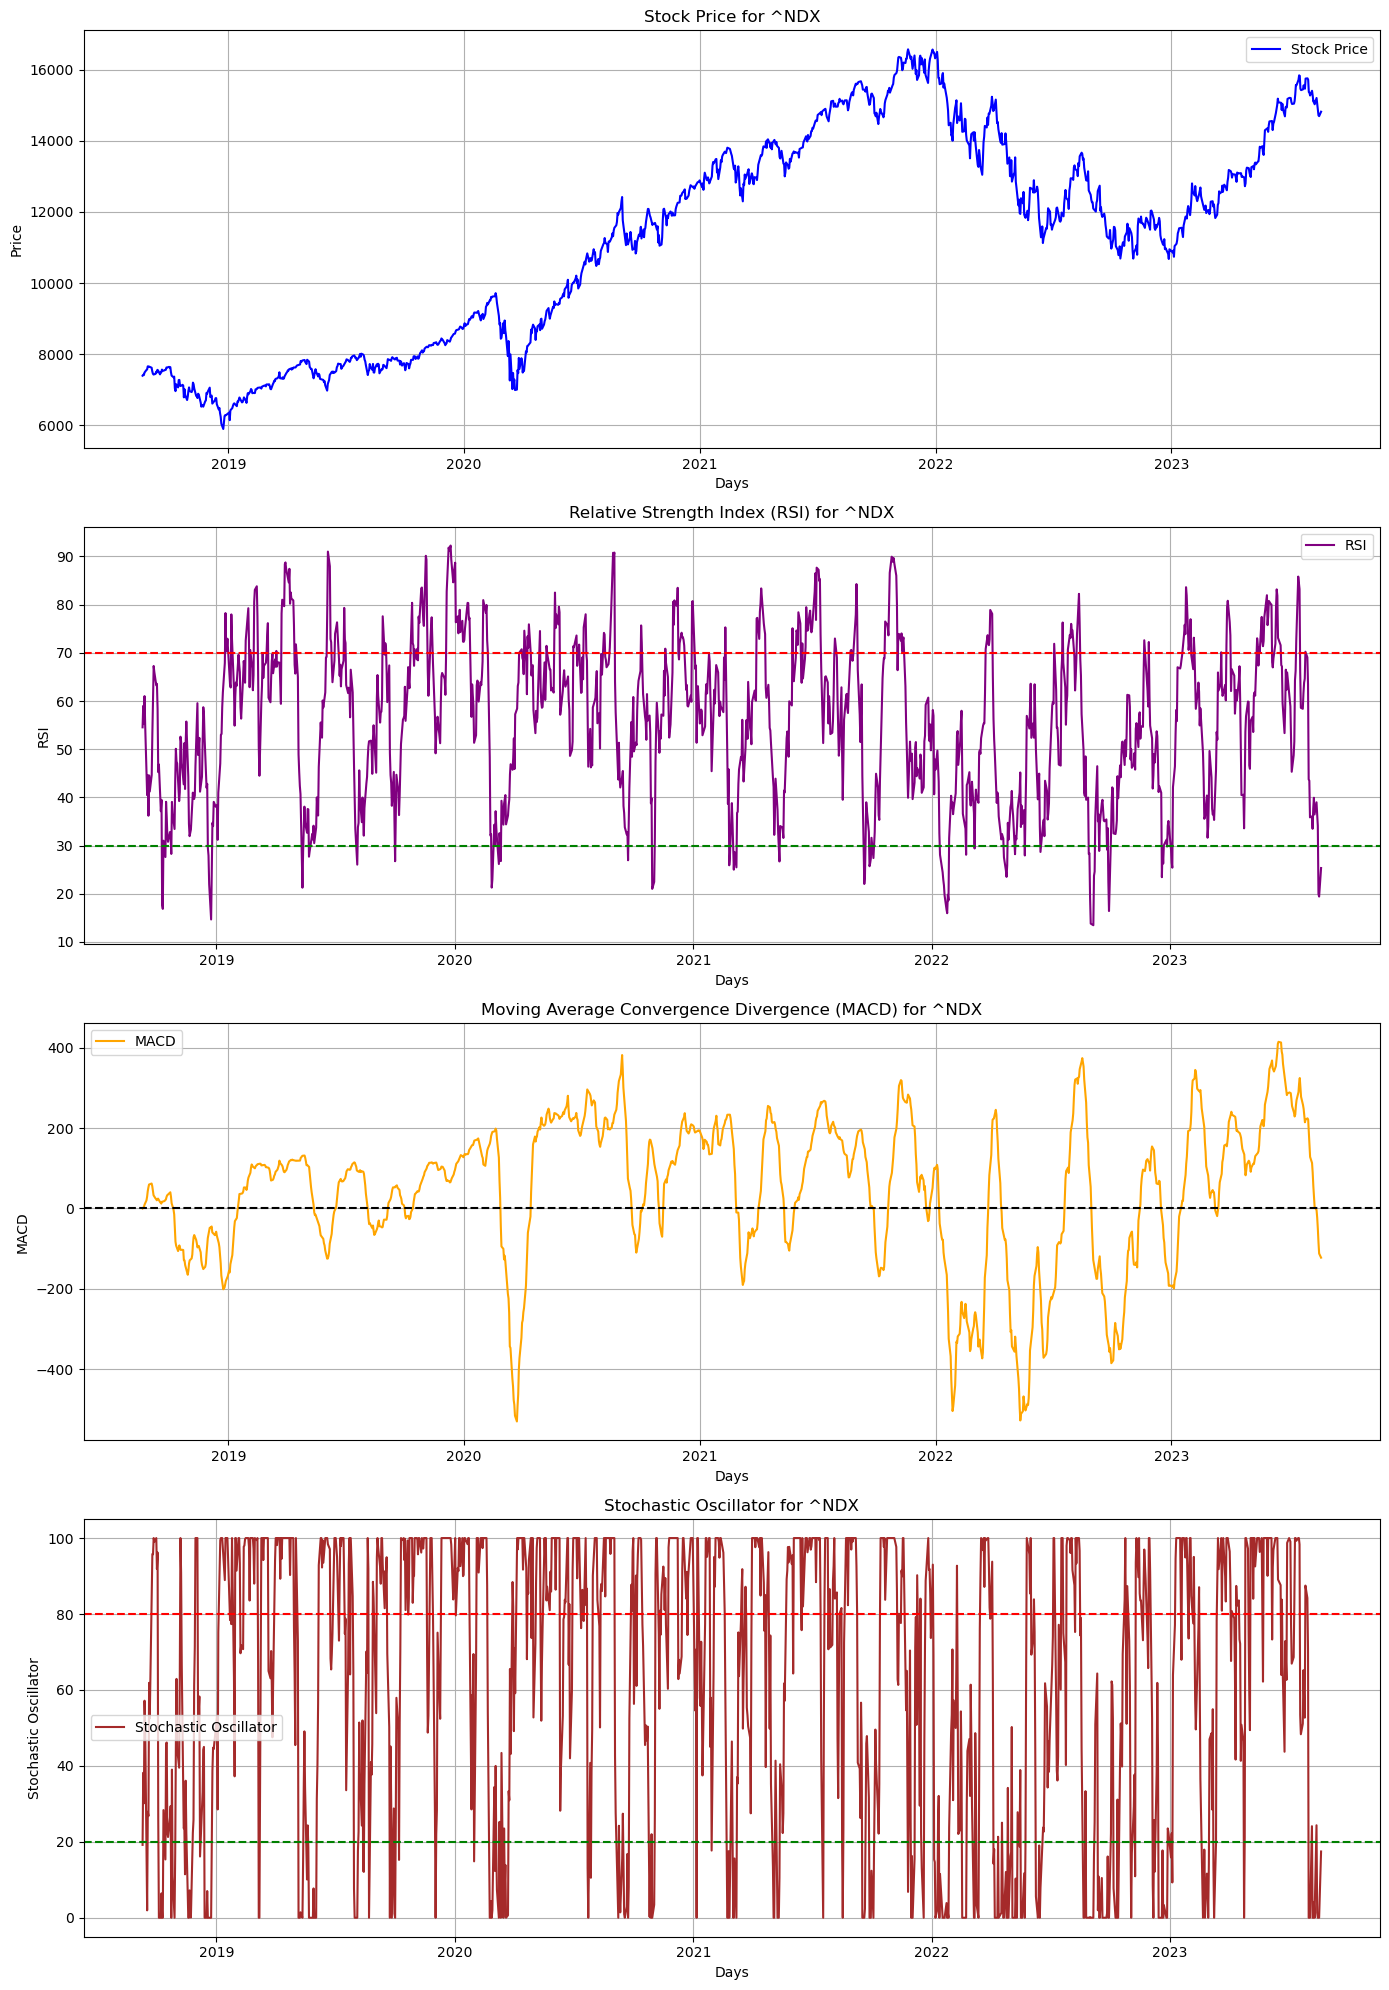

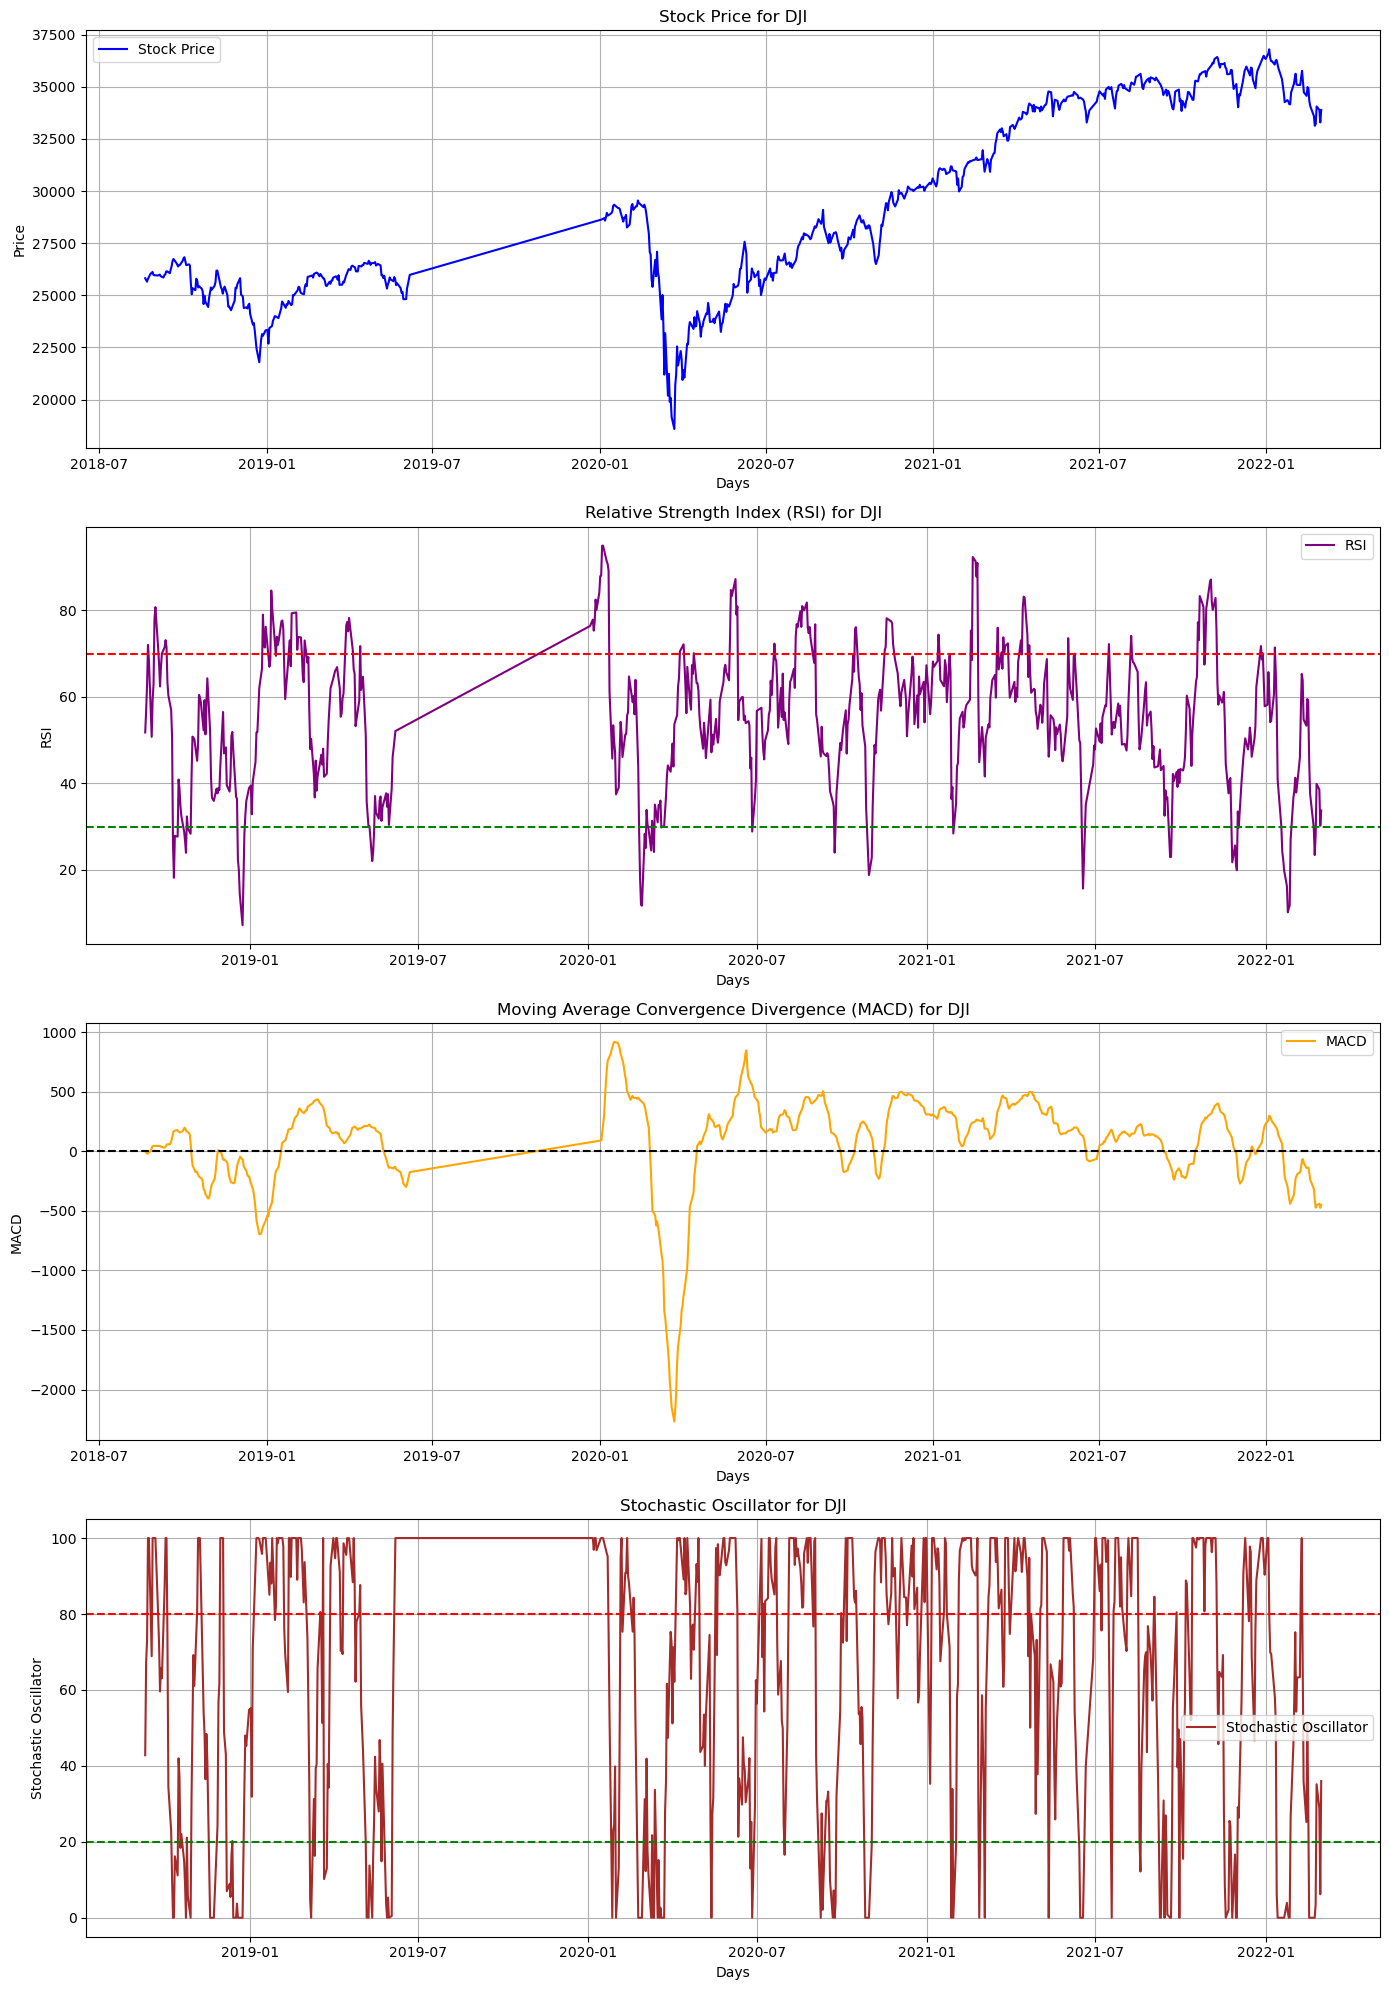

In [17]:
for ticker in tickers:
    df_temp = stock_data[stock_data["Ticker"]==ticker]
    plots_momentum_indicators(df_temp, ticker)

In [18]:
def calculate_bollinger_bands(df, close_column='Close', n_periods=20, k_std_dev=2):
    """
    Calculate Bollinger Bands for a DataFrame.
    
    Parameters:
    - df: DataFrame containing the stock data
    - close_column: Column name for the 'Close' prices
    - n_periods: Number of periods for SMA and standard deviation
    - k_std_dev: Number of standard deviations for the upper and lower bands
    
    Returns:
    - DataFrame with added 'Middle_Band', 'Upper_Band', and 'Lower_Band' columns
    """
    
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Calculate the SMA (Middle Band)
    df_copy['Middle_Band'] = df_copy[close_column].rolling(window=n_periods).mean()
    
    # Calculate standard deviation
    df_copy['SD'] = df_copy[close_column].rolling(window=n_periods).std()
    
    # Calculate the Upper and Lower Bollinger Bands
    df_copy['Upper_Band'] = df_copy['Middle_Band'] + (k_std_dev * df_copy['SD'])
    df_copy['Lower_Band'] = df_copy['Middle_Band'] - (k_std_dev * df_copy['SD'])
    
    return df_copy


In [19]:
df = pd.DataFrame()
for ticker in tickers:
    df_temp = stock_data[stock_data["Ticker"]==ticker]
    df_temp = calculate_bollinger_bands(df_temp)
    df = df.append(df_temp)
    
stock_data = df

/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/495779580.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/495779580.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/495779580.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_7008/495779580.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000

In [20]:
def bollinger_band(stock_data, ticker):

    # Plotting
    plt.figure(figsize=(14, 8))

    # Plot stock prices
    plt.plot(stock_data['Close'], label='Stock Price', color='blue')

    # Plot Bollinger Bands
    plt.plot(stock_data['Middle_Band'], label='Middle Band (20-day SMA)', color='purple')
    plt.plot(stock_data['Upper_Band'], label='Upper Band', color='red')
    plt.plot(stock_data['Lower_Band'], label='Lower Band', color='green')

    plt.title(f'Stock Price and Bollinger Bands for {ticker}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


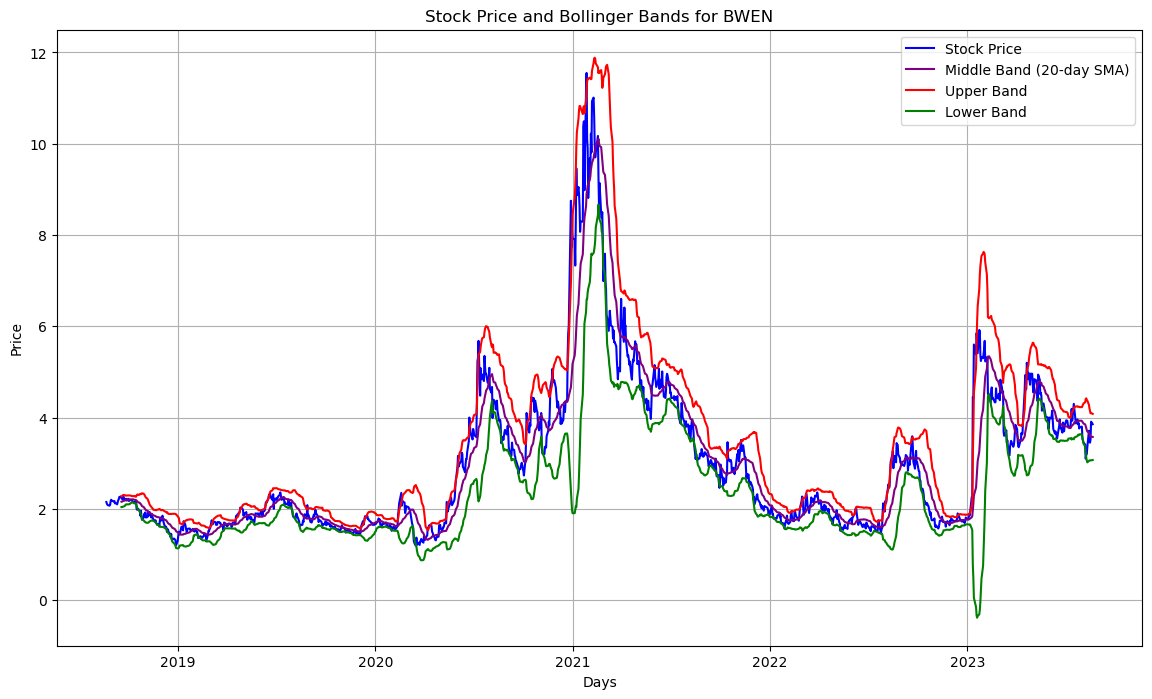

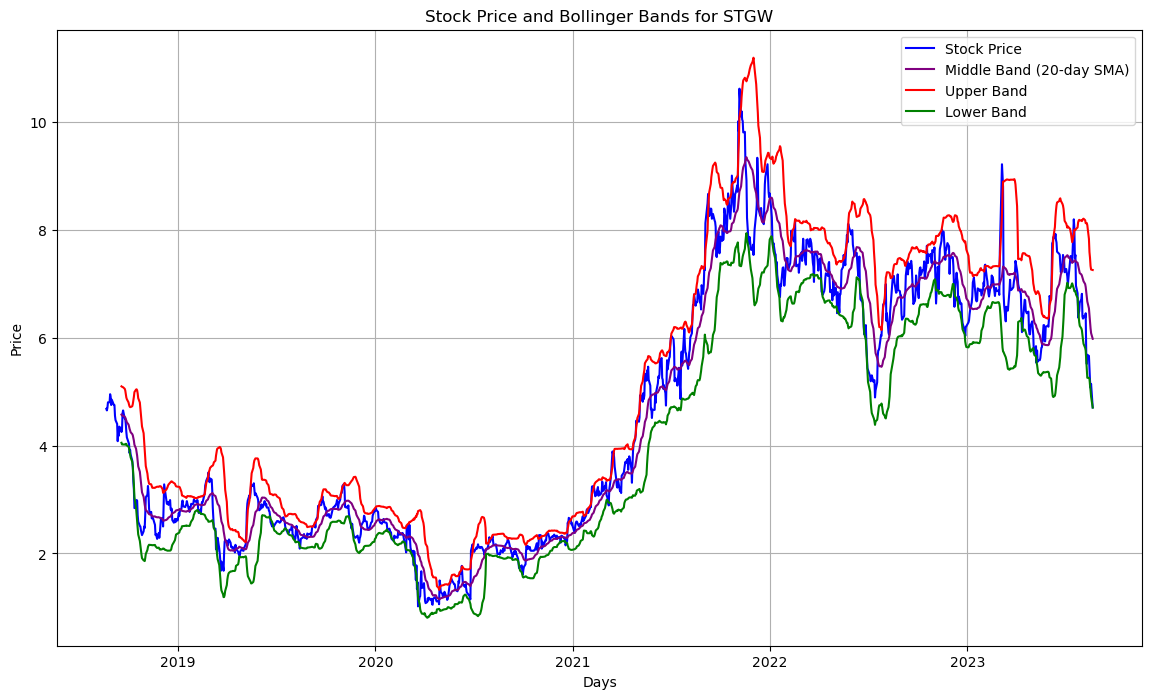

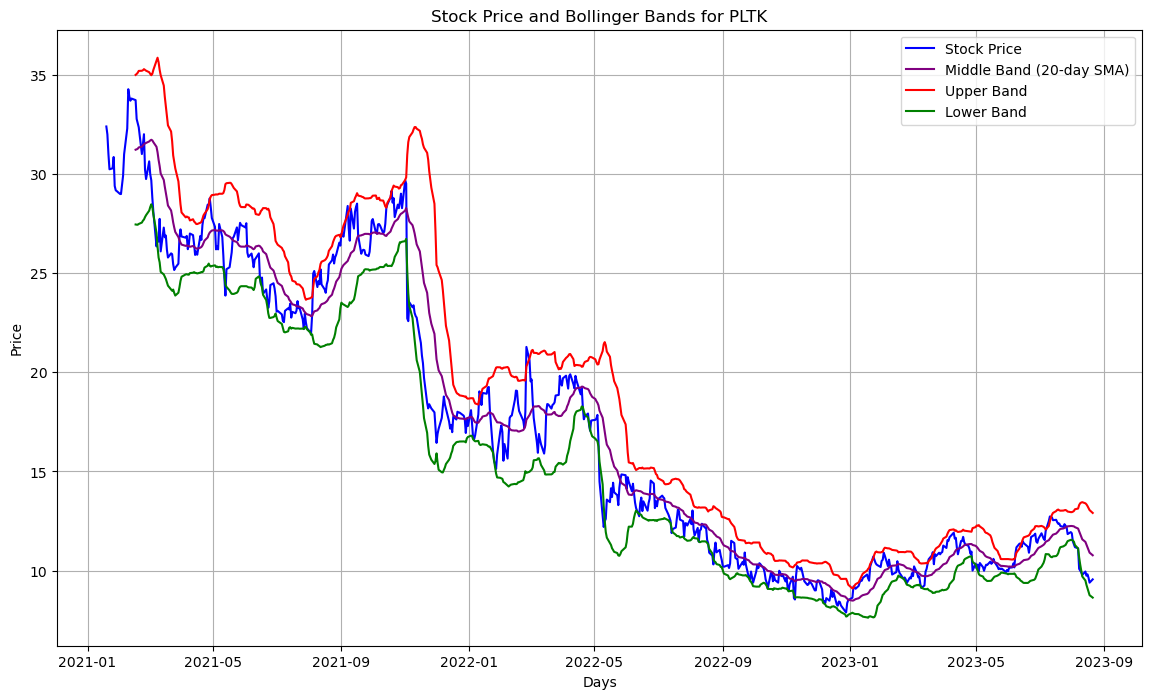

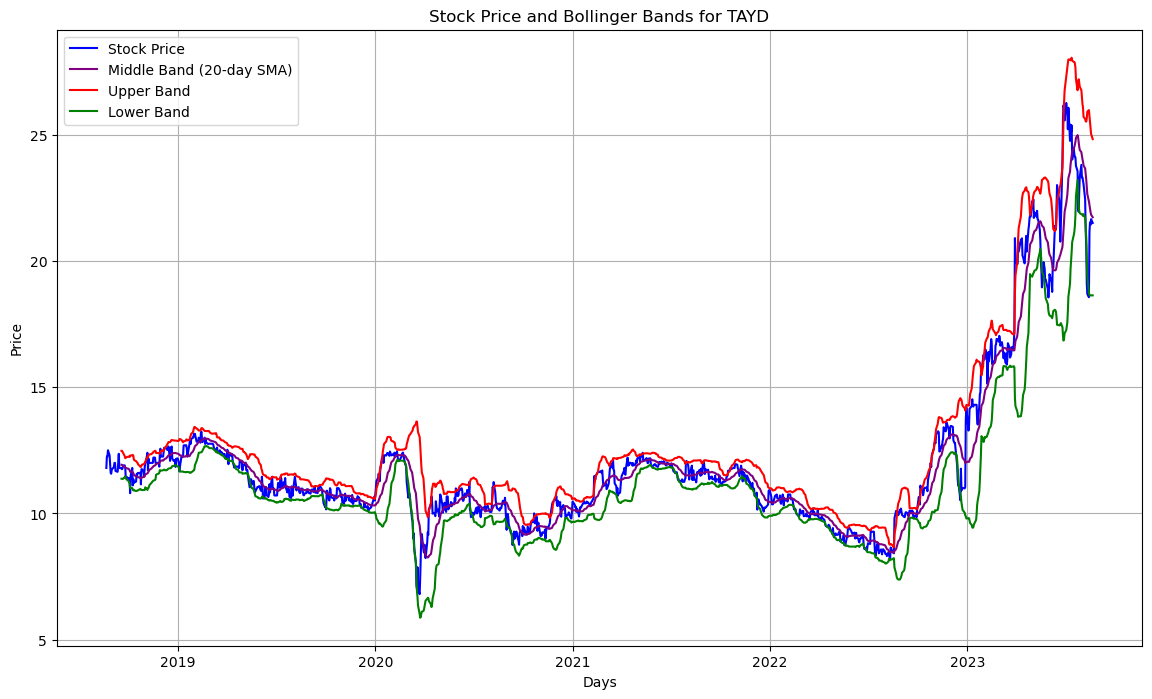

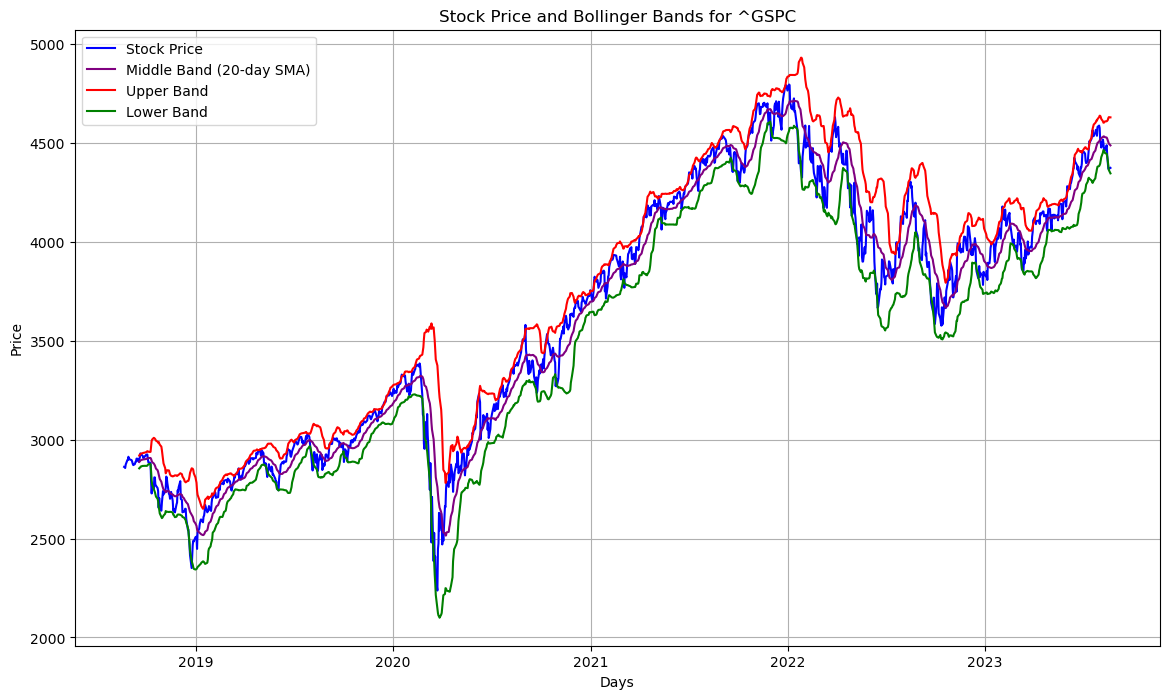

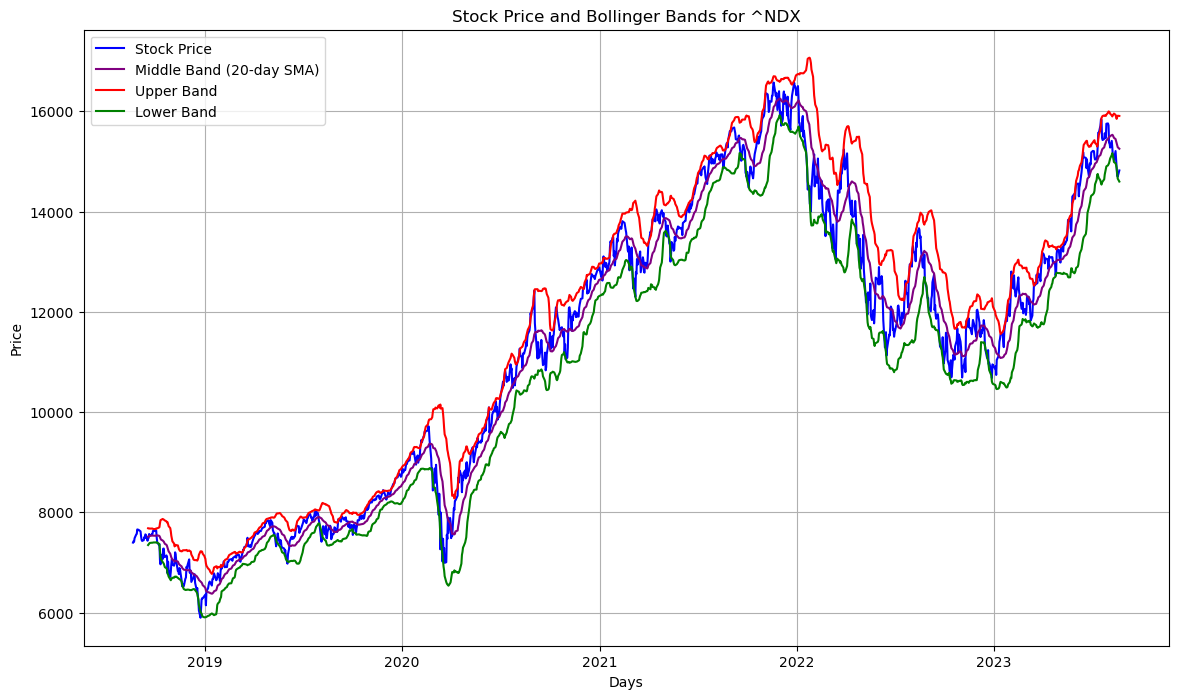

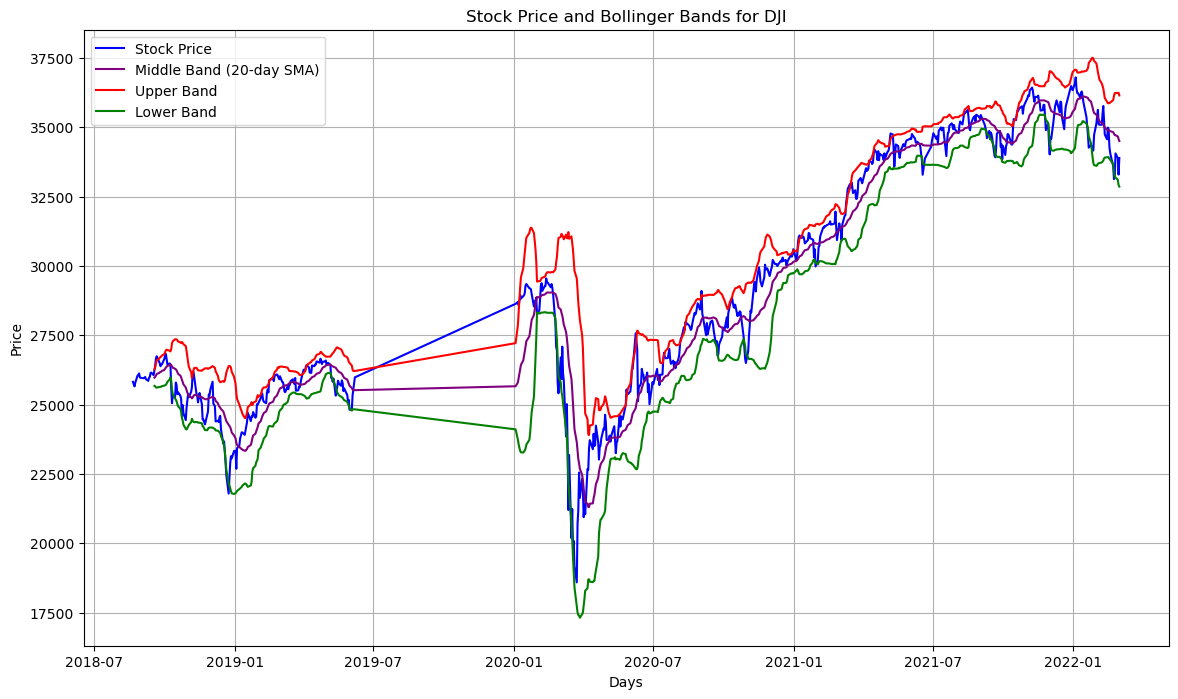

In [21]:
for ticker in tickers:
    df_temp = stock_data[stock_data["Ticker"]==ticker]
    bollinger_band(df_temp, ticker)

In [22]:
def competitors_analyse(df, ticker, competitors, benchmarket):
    # Normalize the data to compare percentage change
    data_normalized = pd.DataFrame()
    for tick in list_stocks:
        data = df[df["Ticker"]==ticker]
        data = data / data.iloc[0] * 100
        data_normalized = data_normalized.append(data)

    # Plotting
    plt.figure(figsize=(14, 8))
    
    plt.plot(data_normalized['Close'], label=f'{ticker} (Target)', color='blue')
    for competitor in competitors: 
        plt.plot(data_normalized['Close'], label=competitor, color='green')

    plt.plot(data_normalized['Close'], label=benchmark, color='red', linestyle='--')

    plt.title('Stock Performance Comparison')
    plt.xlabel('Days')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
def correlation_analysis(data):
    """
    Perform correlation analysis on the given DataFrame and plot the correlation matrix.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing stock prices or other financial metrics.
    
    Returns:
    - correlation_matrix (pd.DataFrame): DataFrame containing the correlation matrix.
    """
    
    # Calculate daily returns
    daily_returns = data.pct_change().dropna()
    
    # Calculate the correlation matrix
    correlation_matrix = daily_returns.corr()
    
    # Plotting the correlation matrix
    plt.figure(figsize=(8, 6))
    plt.title('Correlation Matrix')
    cax = plt.matshow(correlation_matrix, cmap='coolwarm')
    plt.colorbar(cax)
    plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)
    plt.show()
    
    return correlation_matrix


In [24]:
def plot_candlestick(data, title='Candlestick Chart', ylabel='Price', volume=True):
    """
    Create a candlestick chart using mplfinance library.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing Date, Open, High, Low, Close, and Volume columns.
    - title (str): Title of the chart.
    - ylabel (str): Y-axis label for the price.
    - volume (bool): Whether to include volume or not.
    
    Returns:
    - None (The function will plot the chart)
    """
    import mplfinance as mpf
    
    # Create the candlestick plot
    mpf.plot(data, type='candle', style='charles', title=title,
             ylabel=ylabel, ylabel_lower='Volume', volume=volume)

In [25]:
def analyze_candlestick(data, sma_period=20, atr_period=14):
    """
    Analyze candlestick data to identify basic trends and volatility.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing Open, High, Low, Close columns.
    - sma_period (int): The period for the Simple Moving Average to identify trends.
    - atr_period (int): The period for the Average True Range to measure volatility.
    
    Returns:
    - analysis (dict): Dictionary containing trend and volatility information.
    """
    
    # Calculate Simple Moving Average (SMA)
    data['SMA'] = data['Close'].rolling(window=sma_period).mean()
    
    # Calculate Average True Range (ATR)
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=atr_period).mean()
    
    # Identify Support and Resistance
    support = data['Low'].rolling(window=atr_period).min()
    resistance = data['High'].rolling(window=atr_period).max()
    
    # Analyze Trend Direction based on SMA
    latest_sma = data['SMA'].iloc[-1]
    prev_sma = data['SMA'].iloc[-sma_period]
    trend = 'Up' if latest_sma > prev_sma else 'Down' if latest_sma < prev_sma else 'Sideways'
    
    # Average Volatility
    avg_volatility = data['ATR'].mean()
    
    analysis = {
        'Trend': trend,
        'Average Volatility': avg_volatility,
        'Latest Support': support.iloc[-1],
        'Latest Resistance': resistance.iloc[-1]
    }
    
    return analysis

# Sample usage
# Replace this with your actual DataFrame containing Open, High, Low, Close columns
# sample_data = pd.DataFrame({
#     'Open': np.random.rand(100),
#     'High': np.random.rand(100),
#     'Low': np.random.rand(100),
#     'Close': np.random.rand(100)
# })

# result = analyze_candlestick(sample_data)
# print(result)


In [26]:
def advanced_candlestick_analysis(data, sma_period=20, atr_period=14, macd_short=12, macd_long=26, macd_signal=9, rsi_period=14, bollinger_window=20, bollinger_std_dev=2):
    """
    Perform advanced candlestick data analysis.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing Open, High, Low, Close columns.
    - sma_period (int): Period for Simple Moving Average.
    - atr_period (int): Period for Average True Range.
    - macd_short (int): Short period for MACD.
    - macd_long (int): Long period for MACD.
    - macd_signal (int): Signal line period for MACD.
    - rsi_period (int): Period for RSI calculation.
    - bollinger_window (int): Window for Bollinger Bands.
    - bollinger_std_dev (int): Standard deviation for Bollinger Bands.
    
    Returns:
    - analysis (dict): Dictionary containing various analyses.
    """
    
    analysis = {}
    
    # Calculate Simple Moving Average (SMA)
    data['SMA'] = data['Close'].rolling(window=sma_period).mean()
    
    # Calculate Average True Range (ATR)
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=atr_period).mean()
    
    # Calculate MACD and Signal Line
    data['EMA_Short'] = data['Close'].ewm(span=macd_short, adjust=False).mean()
    data['EMA_Long'] = data['Close'].ewm(span=macd_long, adjust=False).mean()
    data['MACD'] = data['EMA_Short'] - data['EMA_Long']
    data['Signal_Line'] = data['MACD'].ewm(span=macd_signal, adjust=False).mean()
    
    # Calculate RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # Calculate Bollinger Bands
    data['Middle_Band'] = data['Close'].rolling(window=bollinger_window).mean()
    data['Upper_Band'] = data['Middle_Band'] + bollinger_std_dev * data['Close'].rolling(window=bollinger_window).std()
    data['Lower_Band'] = data['Middle_Band'] - bollinger_std_dev * data['Close'].rolling(window=bollinger_window).std()
    
    # Populate the analysis dictionary
    analysis['Trend'] = 'Up' if data['SMA'].iloc[-1] > data['SMA'].iloc[-sma_period] else 'Down'
    analysis['Average Volatility'] = data['ATR'].mean()
    analysis['Latest MACD'] = data['MACD'].iloc[-1]
    analysis['Latest Signal Line'] = data['Signal_Line'].iloc[-1]
    analysis['Latest RSI'] = data['RSI'].iloc[-1]
    analysis['Latest Upper Bollinger Band'] = data['Upper_Band'].iloc[-1]
    analysis['Latest Lower Bollinger Band'] = data['Lower_Band'].iloc[-1]
    
    return analysis

# Sample usage (You'll replace this with your actual DataFrame containing Open, High, Low, Close columns)
# sample_data = pd.DataFrame({
#     'Open': np.random.rand(100),
#     'High': np.random.rand(100),
#     'Low': np.random.rand(100),
#     'Close': np.random.rand(100)
# })

# result = advanced_candlestick_analysis(sample_data)
# print(result)


In [27]:
def engle_granger_test(series1, series2):
    """
    Perform the Engle-Granger cointegration test on two time series.
    
    Parameters:
    - series1, series2 (pd.Series): The time series to test.
    
    Returns:
    - result (str): The result of the cointegration test.
    """
    # Step 1: Check for stationarity of individual series
    adf_test1 = adfuller(series1)
    adf_test2 = adfuller(series2)
    
    if adf_test1[1] < 0.05 and adf_test2[1] < 0.05:
        return "Both series are stationary. Cointegration test not applicable."
    
    # Step 2: Test for cointegration
    coint_test = coint(series1, series2)
    
    if coint_test[1] < 0.05:
        return "The series are cointegrated."
    else:
        return "The series are not cointegrated."

# Sample usage:
# result = engle_granger_test(time_series1, time_series2)
# print(result)


In [28]:
def johansen_test(data):
    """
    Perform the Johansen cointegration test on a DataFrame of time series.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the time series to test.
    
    Returns:
    - result (str): The result of the cointegration test.
    """
    # Perform the Johansen test
    johansen_test_result = coint_johansen(data, det_order=0, k_ar_diff=1)
    
    # Extract eigenvalues and critical values for 0.05 significance level
    eigenvalues = johansen_test_result.lr1
    critical_values = johansen_test_result.cvt[:, 1]
    
    # Determine the number of cointegrating vectors
    cointegrating_vectors = sum(eigenvalues > critical_values)
    
    if cointegrating_vectors > 0:
        return f"The series have {cointegrating_vectors} cointegrating vector(s)."
    else:
        return "The series are not cointegrated."

# Sample usage:
# Assume 'data' is a DataFrame containing multiple time series
# result = johansen_test(data)
# print(result)


In [29]:
def fibonacci_retracement(high, low):
    """
    Calculate Fibonacci retracement levels based on a stock's high and low prices.
    
    Parameters:
    - high (float): The highest price of the stock in a given period.
    - low (float): The lowest price of the stock in a given period.
    
    Returns:
    - retracement_levels (dict): A dictionary containing the Fibonacci retracement levels.
    """
    
    # Calculate the difference between the high and low prices
    diff = high - low
    
    # Calculate Fibonacci retracement levels
    retracement_levels = {
        '76.4%': high - 0.764 * diff,
        '61.8%': high - 0.618 * diff,
        '50.0%': high - 0.500 * diff,
        '38.2%': high - 0.382 * diff,
        '23.6%': high - 0.236 * diff,
    }
    
    return retracement_levels

# Example usage:
high_price = 200
low_price = 100
retracement_levels = fibonacci_retracement(high_price, low_price)
print("Fibonacci Retracement Levels:", retracement_levels)


Fibonacci Retracement Levels: {'76.4%': 123.6, '61.8%': 138.2, '50.0%': 150.0, '38.2%': 161.8, '23.6%': 176.4}


In [30]:
import matplotlib.pyplot as plt

def plot_fibonacci_retracement(stock_data, retracement_levels):
    """
    Plot stock prices with Fibonacci retracement levels.
    
    Parameters:
    - stock_data (pd.DataFrame): DataFrame containing 'Date' and 'Close' columns.
    - retracement_levels (dict): Dictionary containing the Fibonacci retracement levels.
    
    Returns:
    - None (Displays a plot).
    """
    
    plt.figure(figsize=(14, 7))
    
    # Plot stock prices
    plt.plot(stock_data['Date'], stock_data['Close'], label='Stock Prices', color='black')
    
    # Plot Fibonacci retracement levels
    for key, value in retracement_levels.items():
        plt.axhline(y=value, color='r', linestyle='--', alpha=0.9, label=f'Fibonacci {key} Retracement Level')
        
    plt.title('Stock Prices with Fibonacci Retracement Levels')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Sample usage:
# # Find the lowest closing price
# low_price = stock_data['Close'].min()

# # Find the highest closing price
# high_price = stock_data['Close'].max()


# Assume 'data' is a DataFrame with 'Date' and 'Close' columns representing stock historical data.
# retracement_levels = fibonacci_retracement(high_price, low_price)
# plot_fibonacci_retracement(data, retracement_levels)


In [31]:
def find_complex_elliott_waves(data):
    """
    Identify potential Elliott Wave sequences in the given data, respecting some core rules.
    
    Parameters:
    - data (pd.Series): Time series data (e.g., stock prices).
    
    Returns:
    - waves (list): List of potential Elliott Wave sequences.
    """
    
    # Identify local minima and maxima
    local_max = data[(data.shift(1) < data) & (data.shift(-1) < data)]
    local_min = data[(data.shift(1) > data) & (data.shift(-1) > data)]

    points = pd.concat([local_max, local_min])
    points.sort_index(inplace=True)
    
    # Simplified Elliott Wave identification respecting core rules
    waves = []
    
    for i in range(len(points) - 4):
        p1, p2, p3, p4, p5 = points.iloc[i:i+5].values
        idx1, idx2, idx3, idx4, idx5 = points.iloc[i:i+5].index
        
        # Wave lengths
        w1 = p2 - p1
        w2 = p3 - p2
        w3 = p4 - p3
        w4 = p5 - p4
        
        # Rule 1: Wave 3 is not the shortest
        if w3 <= min(w1, w2, w4):
            continue
            
        # Rule 2: Wave 2 does not retrace more than 100% of Wave 1
        if abs(w2) >= abs(w1):
            continue
            
        # Rule 3: Wave 4 does not overlap with Wave 1
        if (p4 >= p2 and p4 <= p1) or (p4 <= p2 and p4 >= p1):
            continue
            
        waves.append((idx1, idx2, idx3, idx4, idx5))
        
    return waves

# Sample usage:
# Assume 'data' is a pd.Series containing stock prices
# waves = find_complex_elliott_waves(data)
# print("Potential complex Elliott Waves sequences:", waves)


In [32]:
def plot_complex_elliott_waves(data, waves):
    """
    Plot stock prices with potential Elliott Wave sequences.
    
    Parameters:
    - data (pd.Series): Time series data (e.g., stock prices).
    - waves (list): List of tuples, each containing indices for a potential Elliott Wave sequence.
    
    Returns:
    - None (Displays a plot).
    """
    
    plt.figure(figsize=(14, 7))
    
    # Plot stock prices
    plt.plot(data.index, data.values, label='Stock Prices', color='black')
    
    # Plot potential Elliott Wave sequences
    for wave in waves:
        idx1, idx2, idx3, idx4, idx5 = wave
        plt.plot([idx1, idx2, idx3, idx4, idx5], 
                 [data[idx1], data[idx2], data[idx3], data[idx4], data[idx5]], 
                 label='Potential Elliott Wave', marker='o')
        
    plt.title('Stock Prices with Potential Elliott Waves')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sample usage with hypothetical data and waves
# Assume 'data' is a pd.Series containing stock prices
# Assume 'waves' is a list of tuples returned by the 'find_complex_elliott_waves' function
# plot_complex_elliott_waves(data, waves)


In [33]:
def calculate_alpha_beta(stock_returns, market_returns):
    """
    Calculate Alpha and Beta for a stock relative to a market benchmark.
    
    Parameters:
    - stock_returns (pd.Series): Time series of stock returns.
    - market_returns (pd.Series): Time series of market returns (benchmark).
    
    Returns:
    - alpha (float): Alpha of the stock.
    - beta (float): Beta of the stock.
    """
    
    # Ensure the time series have the same time period
    common_index = stock_returns.index.intersection(market_returns.index)
    stock_returns = stock_returns.loc[common_index]
    market_returns = market_returns.loc[common_index]
    
    # Perform linear regression to get beta
    beta, alpha, r_value, p_value, std_err = stats.linregress(market_returns, stock_returns)
    
    return alpha, beta

# Sample usage:
# Assume 'stock_returns' and 'market_returns' are pd.Series containing the returns
# alpha, beta = calculate_alpha_beta(stock_returns, market_returns)
# print(f"Alpha: {alpha}, Beta: {beta}")


In [34]:
def calculate_expected_return(alpha, beta, risk_free_rate, market_return):
    """
    Calculate the expected return of a stock using the Capital Asset Pricing Model (CAPM).
    
    Parameters:
    - alpha (float): Alpha of the stock.
    - beta (float): Beta of the stock.
    - risk_free_rate (float): Risk-free rate (annualized, in decimal form, e.g., 0.01 for 1%).
    - market_return (float): Expected market return (annualized, in decimal form, e.g., 0.08 for 8%).
    
    Returns:
    - expected_return (float): Expected return of the stock (annualized, in decimal form).
    """
    
    # CAPM formula to calculate expected return
    expected_return = risk_free_rate + beta * (market_return - risk_free_rate) + alpha
    
    return expected_return

# Sample usage:
# Assume you have alpha, beta, a risk-free rate, and expected market return
# expected_return = calculate_expected_return(alpha, beta, 0.01, 0.08)
# print(f"Expected Return: {expected_return:.4f}")


In [35]:
def monte_carlo_simulation(stock_price, mean_return, volatility, num_simulations=1000, num_days=252):
    """
    Perform Monte Carlo simulations to forecast future stock prices.
    
    Parameters:
    - stock_price (float): Current stock price.
    - mean_return (float): Mean return of the stock (annualized, in decimal form).
    - volatility (float): Volatility of the stock (annualized, in decimal form).
    - num_simulations (int): Number of simulations to run.
    - num_days (int): Number of trading days to forecast.
    
    Returns:
    - simulations (np.ndarray): Array containing the simulated future stock price paths.
    """
    
    # Initialize array to store simulations
    simulations = np.zeros((num_days, num_simulations))
    
    # Set the first day's price to the current stock price
    simulations[0] = stock_price
    
    # Generate simulated price paths
    for t in range(1, num_days):
        rand_nums = np.random.normal(0, 1, num_simulations)
        simulations[t] = simulations[t-1] * np.exp((mean_return - 0.5 * volatility ** 2) + volatility * np.sqrt(1) * rand_nums)
    
    # Plot some sample paths
    plt.figure(figsize=(10, 6))
    plt.title("Monte Carlo Simulation of Future Stock Prices")
    plt.xlabel("Trading Days")
    plt.ylabel("Stock Price")
    plt.plot(simulations[:, :10])
    plt.show()
    
    return simulations

# Sample usage:
# Assume you have the current stock price, mean return, and volatility
# simulations = monte_carlo_simulation(stock_price=100, mean_return=0.08, volatility=0.2, num_simulations=1000, num_days=252)


In [36]:
def calculate_var_cvar(stock_returns, confidence_level=0.95, time_horizon=1):
    """
    Calculate Value at Risk (VaR) and Conditional Value at Risk (CVaR) for a stock.
    
    Parameters:
    - stock_returns (np.ndarray): Array of historical stock returns.
    - confidence_level (float): Confidence level for VaR and CVaR (e.g., 0.95 for 95% confidence).
    - time_horizon (int): Time horizon for VaR and CVaR calculation (in days).
    
    Returns:
    - var (float): Value at Risk at the specified confidence level and time horizon.
    - cvar (float): Conditional Value at Risk at the specified confidence level and time horizon.
    """
    
    # Sort the returns in ascending order
    sorted_returns = np.sort(stock_returns)
    
    # Calculate the index corresponding to the (1 - confidence level)
    var_idx = int((1 - confidence_level) * len(sorted_returns))
    
    # Calculate VaR
    var = sorted_returns[var_idx]
    
    # Calculate CVaR as the average of losses worse than VaR
    cvar = np.mean(sorted_returns[:var_idx])
    
    # Adjust for time horizon
    var = var * np.sqrt(time_horizon)
    cvar = cvar * np.sqrt(time_horizon)
    
    return var, cvar

# Sample usage:
# Assume 'stock_returns' is a numpy array containing historical stock returns
# var, cvar = calculate_var_cvar(stock_returns, confidence_level=0.95, time_horizon=1)
# print(f"Value at Risk (VaR): {var}, Conditional Value at Risk (CVaR): {cvar}")


In [37]:
def efficient_frontier(returns, risk_free_rate):
    """
    Compute the efficient frontier for a set of stock returns.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of historical returns for multiple stocks.
    - risk_free_rate (float): Risk-free rate (annualized, in decimal form).
    
    Returns:
    - ef_weights (np.ndarray): Optimal portfolio weights for the efficient frontier.
    - ef_returns (np.ndarray): Expected returns for each point on the efficient frontier.
    - ef_risks (np.ndarray): Corresponding standard deviations (risks) for each point on the efficient frontier.
    """
    
    num_assets = len(returns.columns)
    cov_matrix = returns.cov()
    
    # Create a list of portfolios with varying weights
    ef_weights = []
    ef_returns = []
    ef_risks = []

    for target_return in np.linspace(min(returns.mean()), max(returns.mean()), num=100):
        weights = cp.Variable(num_assets)
        risk = cp.quad_form(weights, cov_matrix)

        objective = cp.Maximize(weights @ returns.mean())
        constraints = [
            cp.sum(weights) == 1,
            weights >= 0,
            cp.sum(cp.multiply(returns.mean(), weights)) == target_return
        ]

        prob = cp.Problem(objective, constraints)
        prob.solve()
        
        ef_weights.append(weights.value)
        ef_returns.append(target_return)
        ef_risks.append(np.sqrt(risk.value))
    
    ef_weights = np.array(ef_weights)
    ef_returns = np.array(ef_returns)
    ef_risks = np.array(ef_risks)
    
    return ef_weights, ef_returns, ef_risks

# Sample usage:
# Assume you have a DataFrame 'stock_returns' containing historical returns of multiple stocks
# risk_free_rate = 0.02  # Risk-free rate in decimal form (e.g., 2% = 0.02)
# ef_weights, ef_returns, ef_risks = efficient_frontier(stock_returns, risk_free_rate)


In [38]:
def asset_allocation(returns, risk_free_rate, target_return):
    """
    Perform asset allocation for a two-stock portfolio.
    
    Parameters:
    - returns (pd.DataFrame): DataFrame of historical returns for multiple stocks.
    - risk_free_rate (float): Risk-free rate (annualized, in decimal form).
    - target_return (float): Target expected return for the portfolio (annualized, in decimal form).
    
    Returns:
    - optimal_weights (np.ndarray): Optimal portfolio weights for the given target return.
    - portfolio_risk (float): Standard deviation (risk) of the portfolio with optimal weights.
    """
    
    num_assets = len(returns.columns)
    cov_matrix = returns.cov()
    
    weights = cp.Variable(num_assets)
    risk = cp.quad_form(weights, cov_matrix)

    objective = cp.Maximize(weights @ returns.mean())
    constraints = [
        cp.sum(weights) == 1,
        weights >= 0,
        cp.sum(cp.multiply(returns.mean(), weights)) == target_return
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    optimal_weights = weights.value
    portfolio_risk = np.sqrt(risk.value)
    
    return optimal_weights, portfolio_risk

# Sample usage:
# Assume you have a DataFrame 'stock_returns' containing historical returns of multiple stocks
# risk_free_rate = 0.02  # Risk-free rate in decimal form (e.g., 2% = 0.02)
# target_return = 0.08  # Target expected return in decimal form (e.g., 8% = 0.08)
# optimal_weights, portfolio_risk = asset_allocation(stock_returns, risk_free_rate, target_return)


In [39]:
"""https://medium.com/private-curator/three-buy-rated-stocks-under-10-and-ready-to-rise-a4691dbb3e39"""

'https://medium.com/private-curator/three-buy-rated-stocks-under-10-and-ready-to-rise-a4691dbb3e39'